# Time Series Study - https://reurl.cc/0oLzpx

- 過去動手做單元曾經出現過的所有資料都可以點擊[這個連結](https://reurl.cc/QdMz09)下載， 縮短網址如後： https://reurl.cc/QdMz09

# 載入常用套件及常數定義

In [1]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/'

import matplotlib as mpl
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('font', size=12)

import datetime 
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import pytz
import math
import datetime as dt
import os
import sys
import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

figure_dir = groot_dir + 'figure/tiempo/'
data_dir = groot_dir + 'tiempo/'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 100)


def print_now() -> None:
    print('Local Time = ', \
        dt.datetime.now(pytz.timezone('Asia/Taipei')))


def timed_message(*args, **kwargs):
    print(*args, **kwargs)
    # print('')
    print_now()


def DropboxLink(did, fname):
    return 'https://dl.dropboxusercontent.com/s/%s/%s' % \
    (did, fname)


def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)


def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = os.path.join(save_in_dir, local_filename)
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier


def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier


def start_plot(figsize=(10, 8), style = 'whitegrid', dpi = 100):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax


def start_plot_hires(figsize=(10, 8), style = 'whitegrid',
        dpi = 200):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax


JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage points to ==>', data_dir)

print('\nThis module is aimed to study time seires basics...') 
print('\nLibraries and dependenciess imported')
print_now()

Mounted at /content/drive

Running on linux
Python Version 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
Data storage points to ==> /content/drive/My Drive/adventures/tiempo/

This module is aimed to study time seires basics...

Libraries and dependenciess imported
Local Time =  2022-12-30 10:13:44.182056+08:00


# 時間序列常用套件

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm

# import pandas_datareader.data as web
# import yfinance as yf

# from pmdarima.arima import auto_arima

# 溫故知新

## 下載 Johns Hopkins University CSSE 所提供資料

In [3]:
selected_rows = lambda d, country: d[d['Country/Region'] == country].iloc[:,4:].sum()
cdata = lambda d, country: d[d['Country/Region'] == country].iloc[:,4:].sum().reset_index().rename(columns={'index':'date', 0:country})  
    
github = JHU_CSSE
jhudata = lambda x: csv_holder % x
csv_holder = 'time_series_covid19_%s_global.csv'

！ 依照疫情的發展狀況，Johns Hopkins 應該會繼續維護疫情資料，以下程式可以繼續使用。若是 JHU 更改格式或遷移放資料的地方，需要修改程式。我想到時大家都應該自己可以應付這種變化了。

In [4]:
#
# helper macros and constant definitions
#
selected_rows = lambda d, country: d[d['Country/Region'] == country].iloc[:,4:].sum()
github = JHU_CSSE
csv_holder = 'time_series_covid19_%s_global.csv'
csvlist = ['confirmed', 'deaths', 'recovered']
put_data_here = data_dir
jhudata = lambda x: csv_holder % x

print(f'data will be stored at {put_data_here:s}')

#
# 從 GitHub 下載資料，儲存在 put_data_here 目錄
#
for dfile in csvlist:
    url = github + csv_holder % dfile
    dled = fetch_file_via_requests(url, put_data_here)
    localname = dled.split('/')[-1]
    print(f'[ {localname:s} ] downloaded and saved')

#
# 從 Dropbox 下載 taiwan.csv
#
fetch_file_via_requests(
    DropboxLink('upr5klwy07bba3h', 'taiwan.csv'), data_dir
)

print('溫故知新： COVID19 data fetched from remote sites')
print_now()

data will be stored at /content/drive/My Drive/adventures/tiempo/
[ time_series_covid19_confirmed_global.csv ] downloaded and saved
[ time_series_covid19_deaths_global.csv ] downloaded and saved
[ time_series_covid19_recovered_global.csv ] downloaded and saved
溫故知新： COVID19 data fetched from remote sites
Local Time =  2022-12-30 10:14:12.386581+08:00


In [5]:
jhudata = lambda x: csv_holder % x
csv_holder = 'time_series_covid19_%s_global.csv'

csv_path = os.path.join(data_dir, 'taiwan.csv')
tdf = pd.read_csv(csv_path, 
    parse_dates = ['date'], index_col = ['date'])

peek = os.path.join(data_dir, jhudata('confirmed'))
peek_r = os.path.join(data_dir, jhudata('recovered'))
peek_d = os.path.join(data_dir, jhudata('deaths'))

df = pd.read_csv(peek)
recovered = pd.read_csv(peek_r)
deaths = pd.read_csv(peek_d)

df.loc[df['Country/Region'] == 'Taiwan*', 'Country/Region'] = 'Taiwan'
deaths.loc[deaths['Country/Region'] == 'Taiwan*', 'Country/Region'] = 'Taiwan'
recovered.loc[recovered['Country/Region'] == 'Taiwan*', 'Country/Region'] = 'Taiwan'
print('溫故知新： COVID19 data loaded and converted to Pandas DataFrame(s)')
print_now()

溫故知新： COVID19 data loaded and converted to Pandas DataFrame(s)
Local Time =  2022-12-30 10:14:17.427219+08:00


In [6]:
df

Province/State        Country/Region        Lat        Long  1/22/20  \
0              NaN           Afghanistan  33.939110   67.709953        0   
1              NaN               Albania  41.153300   20.168300        0   
2              NaN               Algeria  28.033900    1.659600        0   
3              NaN               Andorra  42.506300    1.521800        0   
4              NaN                Angola -11.202700   17.873900        0   
..             ...                   ...        ...         ...      ...   
284            NaN    West Bank and Gaza  31.952200   35.233200        0   
285            NaN  Winter Olympics 2022  39.904200  116.407400        0   
286            NaN                 Yemen  15.552727   48.516388        0   
287            NaN                Zambia -13.133897   27.849332        0   
288            NaN              Zimbabwe -19.015438   29.154857        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/19/22  12/20/22  \
0          0        0        0        0        0  ...    207084    207146   
1          0        0        0        0        0  ...    333653    333686   
2          0        0        0        0        0  ...    271179    271182   
3          0        0        0        0        0  ...     47606     47686   
4          0        0        0        0        0  ...    104946    104946   
..       ...      ...      ...      ...      ...  ...       ...       ...   
284        0        0        0        0        0  ...    703228    703228   
285        0        0        0        0        0  ...       535       535   
286        0        0        0        0        0  ...     11945     11945   
287        0        0        0        0        0  ...    333746    333746   
288        0        0        0        0        0  ...    259356    259981   

     12/21/22  12/22/22  12/23/22  12/24/22  12/25/22  12/26/22  12/27/22  \
0      207190    207239    207262    207310    207399    207438    207460   
1      333708    333708    333731    333749    333749    333751    333751   
2      271186    271190    271193    271194    271198    271198    271202   
3       47686     47686     47686     47686     47686     47686     47686   
4      104973    104973    104973    104973    104973    104973    105095   
..        ...       ...       ...       ...       ...       ...       ...   
284    703228    703228    703228    703228    703228    703228    703228   
285       535       535       535       535       535       535       535   
286     11945     11945     11945     11945     11945     11945     11945   
287    333746    333905    334021    334021    334021    334066    334108   
288    259981    259981    259981    259981    259981    259981    259981   

     12/28/22  
0      207493  
1      333776  
2      271208  
3       47751  
4      105095  
..        ...  
284    703228  
285       535  
286     11945  
287    334196  
288    259981  

[289 rows x 1076 columns]

## JHU CSSE

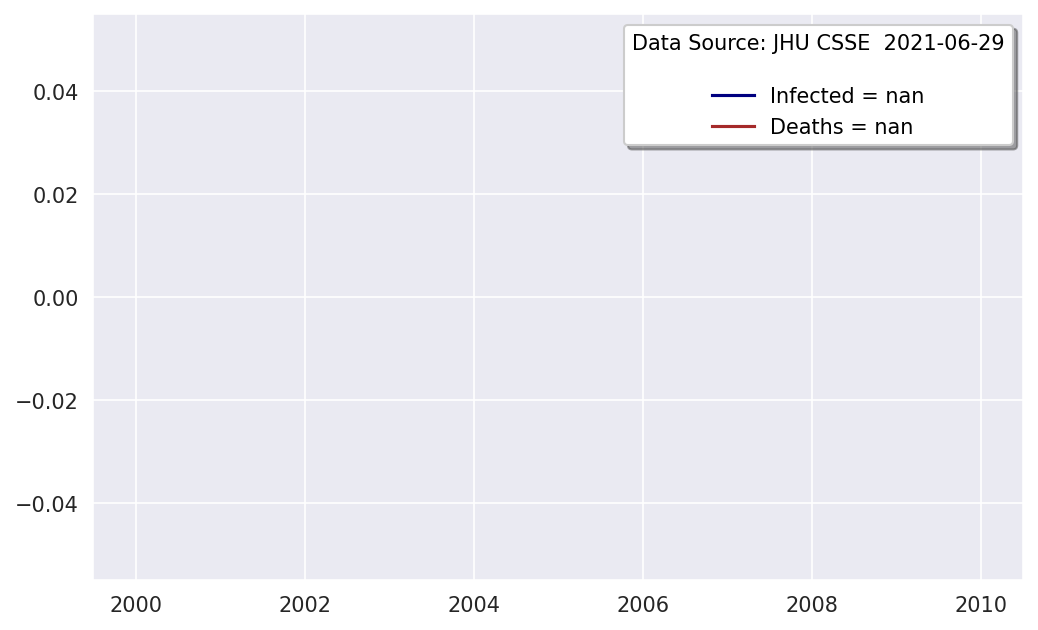

In [ ]:
wdf = pd.DataFrame(data = df.iloc[:, 4:].sum(), 
    index = pd.DatetimeIndex(df.columns[4:]),
    columns = ['Worldwide'])
wdf['Deaths'] = deaths.iloc[:, 4:].sum().astype(int)

ax = start_plot(style='darkgrid', figsize=(8, 5), dpi=150)
ax.plot(wdf.Worldwide, c = 'navy',
    label = 'Infected = {:.4f}'.format(wdf.Worldwide[-1]))
ax.plot(wdf.Deaths, c = 'brown',
    label = 'Deaths = {:.4f}'.format(wdf.Deaths[-1]))
ax.legend( title = 'Data Source: JHU CSSE  %s\n' % \
    str(wdf.index[-1]).split(' ')[0], title_fontsize = 10,
    shadow=True, fancybox=True, fontsize=10)
output_fig('worldwide')

<AxesSubplot:>

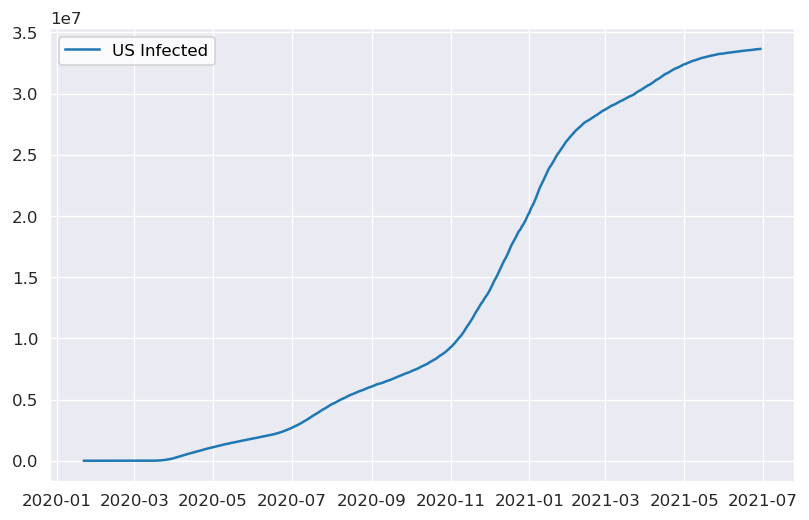

In [ ]:
country = 'US'
data = selected_rows(df, country)
ud = pd.DataFrame(data = data.values, 
    index = pd.DatetimeIndex(data.index) , 
    columns = [f'{country} Infected'])
ax = start_plot(figsize=(8, 5),dpi=120, style='darkgrid')
sns.lineplot(data=ud, ax = ax)

<AxesSubplot:xlabel='date'>

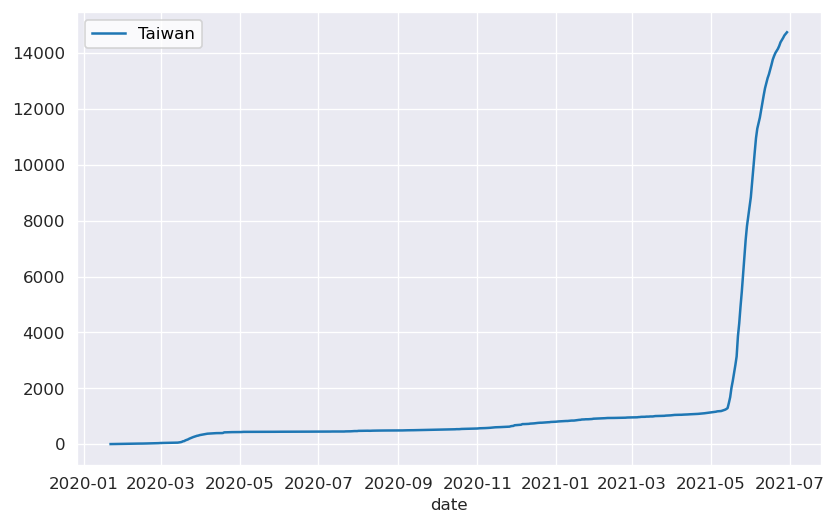

In [ ]:
udf = cdata(df, 'Taiwan')
udf.date = pd.to_datetime(udf.date)
udf.set_index(['date'], drop=True, inplace=True)
ax = start_plot(figsize=(8, 5),dpi=120, style='darkgrid')
sns.lineplot(data=udf, ax = ax)

## taiwan.csv

- [衛福部每日更新](https://data.cdc.gov.tw/dataset/covid19_tw__stats/resource/52eb9a7d-813d-48b1-b462-384a7c84a746)
- [疾病管制署首頁](https://www.cdc.gov.tw)
- [疾病管制署資料開放平台](https://data.cdc.gov.tw)
- [臺灣疫情資料統計 powered by 國家高速網路與計算資料中心（NCHC）](https://covid-19.nchc.org.tw/dt_005-covidTable_taiwan.php)
- [新冠肺炎全球疫情 by Yahoo](https://news.campaign.yahoo.com.tw/2019-nCoV/index.php)
- [UDN 疫情數據全報導](https://udn.com/news/COVID19)：此報導會每日更新網頁內容

根據 2020-08-01 記者會公佈資料：

> 指揮中心統計，國內截至目前累計81,826例(含80,728例排除)，其中474例確診，分別為382例境外移入，55例本土病例、36例敦睦艦隊及**<u>1例待釐清</u>**。

因此自8月1日起，taiwan.csv 資料增加一個欄位 tbd (to_be_decided)，更名為 taiwan_aug.csv，此一 **<u>公開版本</u>**會維護到 2020-08-10。

更新於： 2020/08/02


### 補充說明：

自 2020年10月起，Johns Hopkins University、臺灣衛生福利部以及國內媒體自行統計的資料間不同步的情況越來越多，校對起來越來越困難，為避免內容與研究單位資料不一致造成的誤解，taiwan.csv 和 taiwan_aug.csv 的資料內容會凍結，不再更新。

taiwan.csv 和 taiwan_aug.csv 的用途是練習程式與製圖的技巧，不是正式的（流行病學）學術資料，請大家要明白與體諒。衛生福利部[每日更新](https://data.cdc.gov.tw/dataset/covid19_tw__stats/resource/52eb9a7d-813d-48b1-b462-384a7c84a746)一個檔案，包括確診,解除隔離,死亡,送驗,排除,昨日確診,昨日排除,昨日送驗等欄位，如果大家有需要，請到衛福部網站下載。

更新於： 2020/10/30

建議要自行觀察研究相關資料的同學，使用衛福部疾病管制署的資料，並交叉檢查國家高速網路中心 NCHC 與其他媒體轉載的資料，國家高速網路中心的資料比衛福部略慢，但是比其他坊間大衆傳媒正確。

更新於：2020/11/10

### 補充說明 #2:

自從 Kaggle 辦了幾次 COVID19 預測競賽之後，有熱心人士將 phase-dependent SIR-derived ODE model 製作成 Python package [CovsirPhy](https://lisphilar.github.io/covid19-sir/index.html)，有興趣的人可以安裝這個套件，這個套件的說明文件，包含相關資料的超連結，大家可以循超連結的說明，自己進修研究。

這個套件使用由正在攻讀計量財務分析的義大利博士研究生 [Emanuele Guidotti](https://guidotti.dev/) 所維護的 [COVID-19 Data Hub](https://covid19datahub.io/) 計畫的資料庫。

更新於：2020/11/27

### 補充說明 #3:

衛福部疾病管制署網站的《[新聞稿](https://www.cdc.gov.tw/Bulletin/List/MmgtpeidAR5Ooai4-fgHzQ)》單元，每日公佈最新的相關數字，關注疫情動向的同學，請參考這個公部門公佈的最權威數字。

更新於：2020/12/12

In [ ]:
fetch_file_via_requests(
    DropboxLink('upr5klwy07bba3h', 'taiwan.csv'), data_dir )

fetch_file_via_requests(
    DropboxLink('sfxv53gspz8w6mv', 'taiwan_aug.csv'), data_dir )

'C:\\Users\\wonglab/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/tiempo/taiwan_aug.csv'

In [ ]:
fetch_file_via_requests(
    DropboxLink('upr5klwy07bba3h', 'taiwan.csv'), data_dir )

'C:\\Users\\wonglab/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/tiempo/taiwan.csv'

In [ ]:
fetch_file_via_requests(
    DropboxLink('sfxv53gspz8w6mv', 'taiwan_aug.csv'), 
    data_dir )

'C:\\Users\\wonglab/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/tiempo/taiwan_aug.csv'

In [ ]:
csv_path = os.path.join(data_dir, 'taiwan.csv')
tdf = pd.read_csv(csv_path, 
    parse_dates = ['date'], index_col = ['date'])
tdf.tail()

Taiwan  Local  Imported  Deaths  Recovered  Panshi
date                                                          
2020-07-27     462     55       371       7        440      36
2020-07-28     467     55       376       7        440      36
2020-07-29     467     55       376       7        440      36
2020-07-30     467     55       376       7        440      36
2020-07-31     467     55       376       7        440      36

In [ ]:
csv_aug = os.path.join(data_dir, 'taiwan_aug.csv')
tdf_aug = pd.read_csv(csv_aug, 
    parse_dates = ['date'], index_col = ['date'])
print_now()
tdf_aug.tail()

Local Time =  2021-06-30 13:34:53.264939+08:00


Taiwan  Local  Imported  Deaths  Recovered  Panshi  tbd
date                                                               
2020-12-20     766     55       674       7        627      36    1
2020-12-21     766     55       674       7        627      36    1
2020-12-22     770     56       677       7        632      36    1
2020-12-23     776     56       683       7        635      36    1
2020-12-24     776     56       683       7        635      36    1

In [ ]:
tdf_aug.describe()

Taiwan       Local    Imported      Deaths   Recovered      Panshi  \
count  338.000000  338.000000  338.000000  338.000000  338.000000  338.000000   
mean   413.298817   46.970414  339.559172    5.594675  348.837278   26.340237   
std    200.396927   16.829720  172.268624    2.473282  203.479160   15.697991   
min      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%    395.000000   55.000000  340.000000    6.000000  141.500000    0.000000   
50%    449.000000   55.000000  358.000000    7.000000  438.000000   36.000000   
75%    514.750000   55.000000  422.750000    7.000000  483.500000   36.000000   
max    776.000000   56.000000  683.000000    7.000000  635.000000   36.000000   

              tbd  
count  338.000000  
mean     0.431953  
std      0.496082  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000

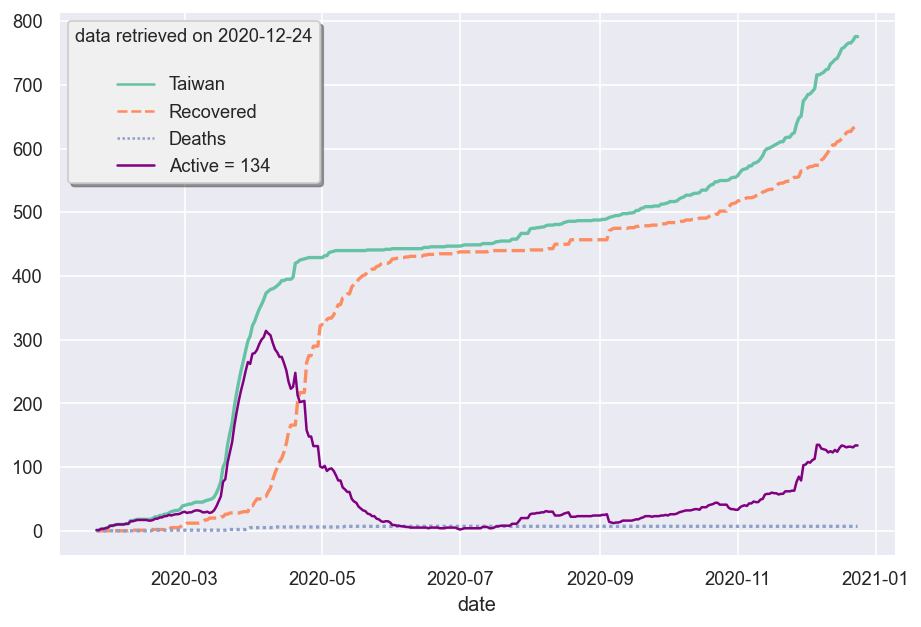

In [ ]:
# ax = start_plot(style='darkgrid', figsize=(9, 6), dpi=120)
import seaborn as sns
sns.set(style='darkgrid')
_, ax = plt.subplots(figsize=(9, 6), dpi=120)
tdf2 = tdf_aug[['Taiwan', 'Recovered', 'Deaths']]

# tdf2.plot(kind='line', ax=ax)
sns.lineplot(data = tdf2, palette = 'Set2', lw = 2, ax=ax)
ax.plot(tdf2.Taiwan - tdf2.Recovered - tdf2.Deaths,
    c = 'purple', label = 'Active = %d' % \
    (tdf2.Taiwan[-1] - tdf2.Recovered[-1] - tdf2.Deaths[-1]))

ax.legend(title = 'data retrieved on %s\n' % \
    str(tdf2.index[-1]).split(' ')[0], 
    title_fontsize = 11, facecolor='#f0f0f0', shadow=True)

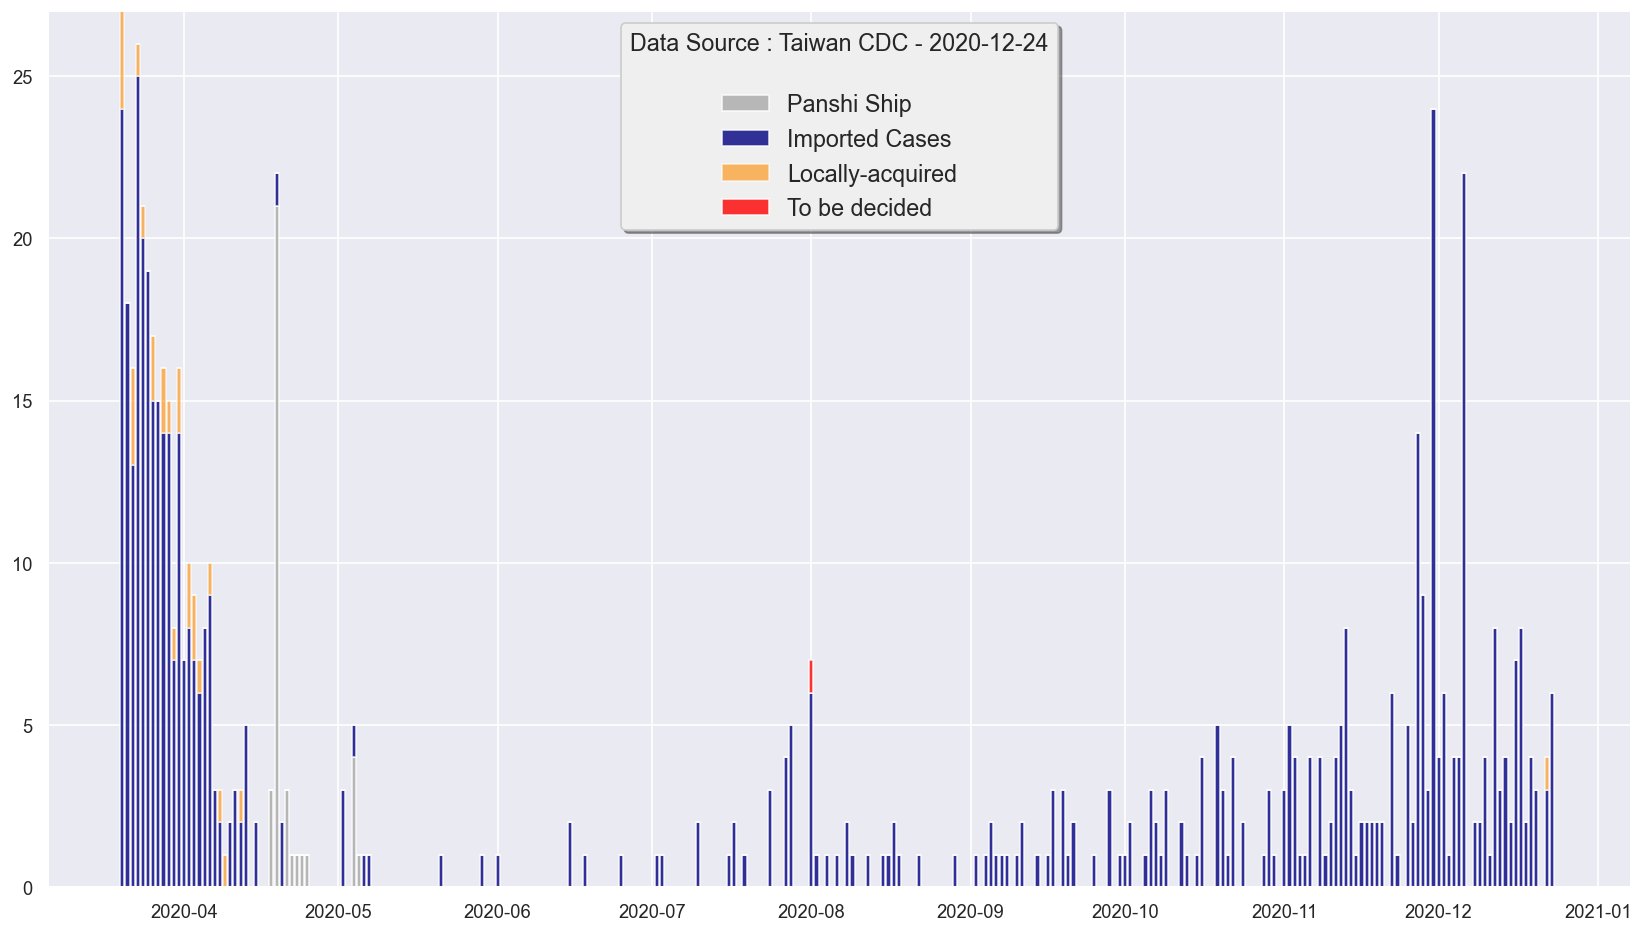

In [ ]:
zdf = pd.DataFrame()

zdf = tdf_aug[['Taiwan', 'Local', 'Imported', 'Panshi', 'tbd']]
# zdf['Taiwan'] = tdf_aug.Taiwan.diff(1)
# zdf['Local'] = tdf_aug.Local.diff(1)
# zdf['Imported'] = tdf_aug.Imported.diff(1)
# zdf['Panshi'] = tdf_aug.Panshi.diff(1)
# zdf['tbd'] = tdf_aug.tbd.diff(1)
zdf = zdf.diff(1)[1:]


zdf = zdf[-280:]

fig,ax = plt.subplots(figsize=(14,8), dpi = 120)
plt.tight_layout()
ax.bar(zdf.index, zdf.Panshi, color = 'darkgray', alpha = 0.8, label = 'Panshi Ship')
ax.bar(zdf.index, zdf.Imported, color = 'navy', alpha = 0.8,
       bottom = zdf.Panshi, label = 'Imported Cases')
ax.bar(zdf.index, zdf.Local, color = 'darkorange', alpha = 0.6, 
       label = "Locally-acquired",
       bottom = zdf.Panshi + zdf.Imported)
ax.bar(zdf.index, zdf.tbd, color = 'red', alpha = 0.8, 
       label = "To be decided",
       bottom = zdf.Panshi + zdf.Imported + zdf.Local)
ax.legend( title = 'Data Source : Taiwan CDC - %s\n' % str(zdf.index[-1]).split(' ')[0], 
    title_fontsize = 14, facecolor='#f0eff0',
    loc = 'best', frameon = True, shadow = True, fontsize = 14)
# output_fig('Daily Cases %s' % str(zdf.index[-1]).split(' ')[0])

# 時間序列範例

 [Air Line Passengers from 1949 to 1960](https://www.kaggle.com/chirag19/air-passengers) & [Daily Minimum Temperature in Melbouren](https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne)，是從 Kaggle 平台收集的。
 
Amtrak Data 是一本教科書的範例資料，其他資料，則是由 [ritvikmath](http://ritvikmath.com/) 網站提供的。

In [ ]:
fetch_file_via_requests(
    DropboxLink('udj6cygjgoi6upi','AirPassengers.csv' ), 
    data_dir)

fetch_file_via_requests(
    DropboxLink('lqt5rplifpc1h1f', 
    'daily-minimum-temperatures-in-me.csv'), data_dir )

fetch_file_via_requests(
    DropboxLink('epv47nzdegkhcay', 
    'Amtrak data.csv'), data_dir )

fetch_file_via_requests(
    DropboxLink('lemgwxxl1simbwi','ice_cream.csv' ), 
    data_dir)

fetch_file_via_requests(
    DropboxLink('z78zc2y6q8by5f1','catfish.csv' ), 
    data_dir)

'C:\\Users\\wonglab/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/tiempo/catfish.csv'

## AirPassengers

In [ ]:
import statsmodels.api as sm
def simple_ols(xvec, yvec):
    Xadd = sm.add_constant(xvec) # adding a constant
    model = sm.OLS(yvec, Xadd).fit()   
    return model

In [ ]:
passenger_csv = os.path.join(data_dir, 'AirPassengers.csv')
df0 = pd.read_csv(passenger_csv)
df0.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df = pd.read_csv(passenger_csv, index_col=0, parse_dates=['Month'])
#將Month column當作日期來解讀
df.head()

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


<AxesSubplot:xlabel='Month'>

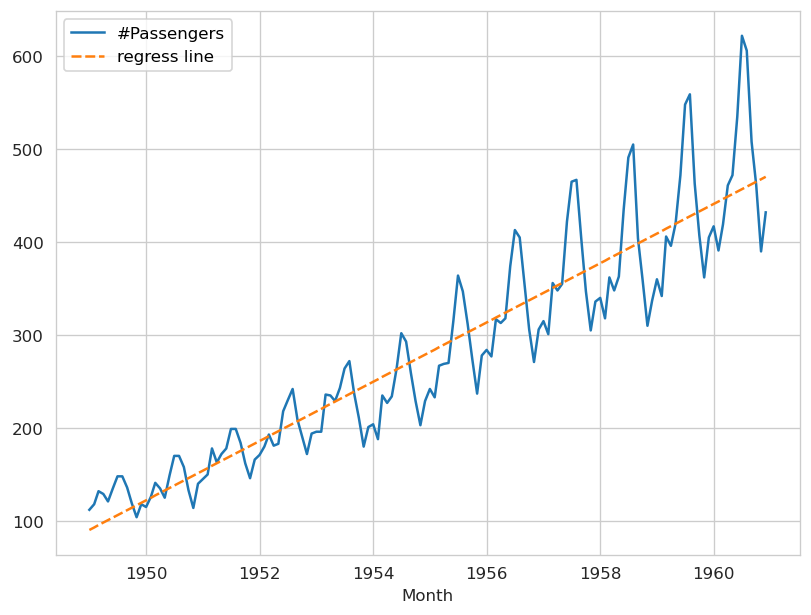

In [ ]:
ax = start_plot(figsize=(8, 6), dpi=120)
model = simple_ols(np.arange(0, len(df), 1), df['#Passengers'])
df_pas = df.copy()
df_pas['regress line'] = model.fittedvalues
sns.lineplot(data=df_pas, ax=ax)
# ax.plot(df_pas.index, model.fittedvalues, color='indianred', ls='--')

In [ ]:
df_pas.head()

#Passengers  regress line
Month                                
1949-01-01          112     90.309962
1949-02-01          118     92.967146
1949-03-01          132     95.624330
1949-04-01          129     98.281513
1949-05-01          121    100.938697

<font color='yellow'>將DataFrame時間欄位索引好處:可在matplotlib, seaborn等套件較為方便

## temperature

In [ ]:
temp_csv = os.path.join(data_dir, 'daily-minimum-temperatures-in-me.csv')
melbourne = pd.read_csv(temp_csv, error_bad_lines=False)
melbourne.head()

b'Skipping line 3653: expected 2 fields, saw 3\n'


Date Daily minimum temperatures in Melbourne, Australia, 1981-1990
0  1981-01-01                                               20.7           
1  1981-01-02                                               17.9           
2  1981-01-03                                               18.8           
3  1981-01-04                                               14.6           
4  1981-01-05                                               15.8

In [ ]:
mel = pd.read_csv(temp_csv, error_bad_lines=False, index_col=0, parse_dates=['Date'])
mel.head()

b'Skipping line 3653: expected 2 fields, saw 3\n'


Daily minimum temperatures in Melbourne, Australia, 1981-1990
Date                                                                    
1981-01-01                                               20.7           
1981-01-02                                               17.9           
1981-01-03                                               18.8           
1981-01-04                                               14.6           
1981-01-05                                               15.8

In [ ]:
mel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   Daily minimum temperatures in Melbourne, Australia, 1981-1990  3650 non-null   object
dtypes: object(1)
memory usage: 57.0+ KB


<font color='yellow'>觀察到此資料結構TYPE為STRING

In [ ]:
col_name = 'Daily minimum temperatures in Melbourne, Australia, 1981-1990'
mel[col_name] = pd.to_numeric(mel[col_name], errors='coerce')
mel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Daily minimum temperatures in Melbourne, Australia, 1981-1990  3647 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [ ]:
mel.isna().sum()
mel.loc[mel[col_name] == np.nan]

Empty DataFrame
Columns: [Daily minimum temperatures in Melbourne, Australia, 1981-1990]
Index: []

In [ ]:
mel.fillna(mel.mean(), inplace=True)
mel.head()

Daily minimum temperatures in Melbourne, Australia, 1981-1990
Date                                                                     
1981-01-01                                               20.7            
1981-01-02                                               17.9            
1981-01-03                                               18.8            
1981-01-04                                               14.6            
1981-01-05                                               15.8

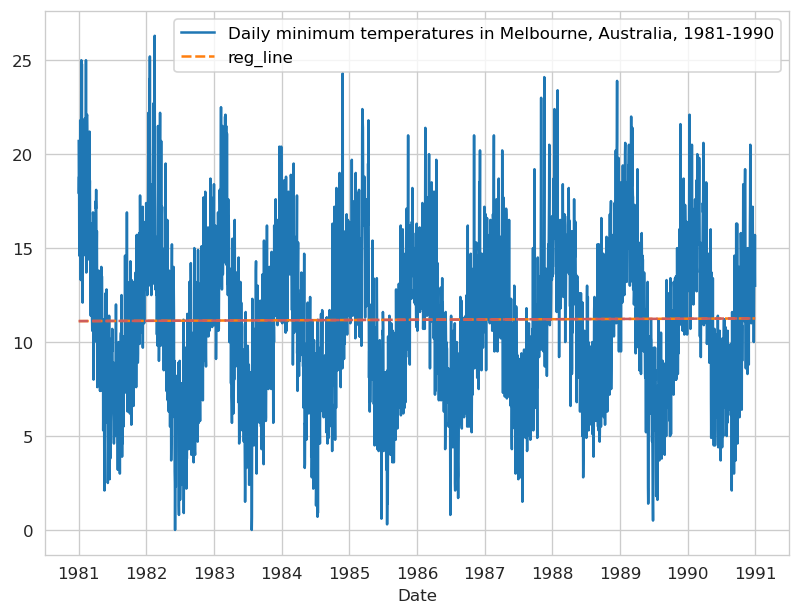

In [ ]:
model_2 = simple_ols(np.arange(0, len(mel), 1), mel[col_name])
df_mel = mel.copy()
df_mel['reg_line'] = model_2.fittedvalues

ax = start_plot(figsize=(8, 6), dpi=120)
sns.lineplot(data=df_mel, ax=ax)
ax.plot(df_mel.index, model_2.fittedvalues, color='indianred', ls='--')

## ice cream

In [ ]:
filepath = os.path.join(data_dir, 'ice_cream.csv')
ice = pd.read_csv(filepath, index_col = 0, 
    parse_dates=['DATE'])
ice.rename(columns={'IPN31152N':'production'}, inplace=True)
ice.head()


production
DATE                  
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636

<AxesSubplot:xlabel='DATE'>

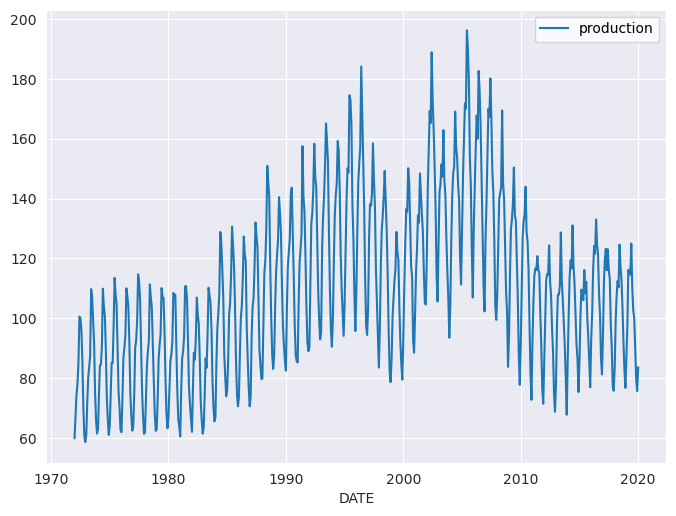

In [ ]:
ax = start_plot(style='darkgrid', figsize=(8, 6))
sns.lineplot(data=ice, ax=ax)

<AxesSubplot:xlabel='DATE'>

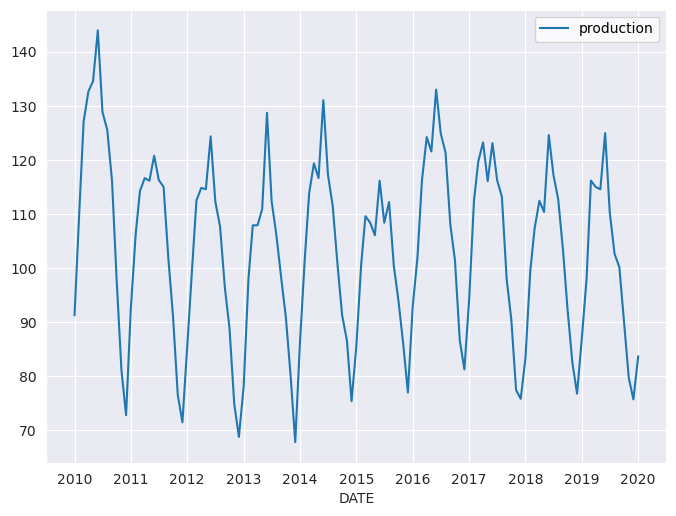

In [ ]:
df21 = ice['2010-01-01':]
ax = start_plot(style='darkgrid', figsize=(8, 6))
sns.lineplot(data=df21, ax=ax)

## Amtrak

In [ ]:
filepath = os.path.join(data_dir, 'Amtrak data.csv')
data = pd.read_csv(filepath)
data = data.dropna()
data

Month  Ridership
0    Jan-91   1708.917
1    Feb-91   1620.586
2    Mar-91   1972.715
3    Apr-91   1811.665
4    May-91   1974.964
..      ...        ...
154   3-Nov   2076.054
155   3-Dec   2140.677
156   4-Jan   1831.508
157   4-Feb   1838.006
158   4-Mar   2132.446

[159 rows x 2 columns]

### Method 1

In [ ]:
date_rng = pd.date_range(start='1991-1-1', end='2004-4-1', freq='M')
amt1 = pd.DataFrame(index=date_rng, data=data.Ridership.values, columns=['Ridership'])
amt1.head()

Ridership
1991-01-31   1708.917
1991-02-28   1620.586
1991-03-31   1972.715
1991-04-30   1811.665
1991-05-31   1974.964

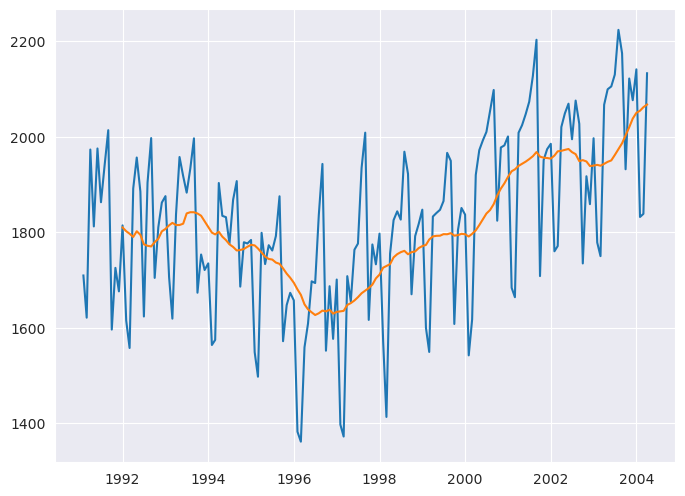

In [ ]:
ax = start_plot(style='darkgrid', figsize=(8, 6))
ax.plot(amt1.Ridership)
ax.plot(amt1.Ridership.rolling(window=12).mean())

### Method 2

In [ ]:
file_path = os.path.join(data_dir, 'Amtrak data.csv')
data = pd.read_csv(filepath, index_col=['Month'], parse_dates=['Month'])
data = data.dropna()
data

Ridership
Month            
Jan-91   1708.917
Feb-91   1620.586
Mar-91   1972.715
Apr-91   1811.665
May-91   1974.964
...           ...
3-Nov    2076.054
3-Dec    2140.677
4-Jan    1831.508
4-Feb    1838.006
4-Mar    2132.446

[159 rows x 1 columns]

# 盡信書不如無書

- [The Lahman Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) & [Documentation](http://www.seanlahman.com/files/database/readme2017.txt)

- [Baseball data analytics fun](https://medium.com/@stuart.zussman/baseball-data-analytics-fun-554137b7f101)
- [維基百科：棒球數據](https://zh.wikipedia.org/wiki/%E6%A3%92%E7%90%83%E7%B5%B1%E8%A8%88#%E6%89%93%E6%93%8A%E6%95%B8%E6%93%9A)
- [打擊數據篇](https://terryex.pixnet.net/blog/post/36215363#:~:text=%E3%80%8C%E6%89%93%E6%95%B8%E3%80%8D%E7%9A%84%E6%AD%A3%E5%BC%8F%E5%90%8D%E7%A8%B1,%E6%93%8A%E6%88%96%E6%98%AF%E5%A6%A8%E7%A4%99%E6%89%93%E6%93%8A%E3%80%82)
------
- playerID       Player ID code
- yearID         Year
- stint          player's stint (order of appearances within a season)
- teamID         Team
- lgID           League
- G              Games
- AB             At Bats
- R              Runs
- H              Hits
- 2B             Doubles
- 3B             Triples
- HR             Homeruns
- RBI            Runs Batted In
- SB             Stolen Bases
- CS             Caught Stealing
- BB             Base on Balls
- SO             Strikeouts
- IBB            Intentional walks
- HBP            Hit by pitch
- SH             Sacrifice hits
- SF             Sacrifice flies
- GIDP           Grounded into double plays

In [ ]:
fetch_file_via_requests(
    DropboxLink('hhl3b3ddsqc6nmf', 'Teams.csv'), data_dir )

'C:\\Users\\wonglab/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/tiempo/Teams.csv'

In [ ]:
stat_csv = os.path.join(data_dir, 'Teams.csv')
mlb = pd.read_csv(stat_csv)
mlb.head()

yearID lgID teamID franchID divID  Rank   G  Ghome   W   L  ...  DP     FP  \
0    1871  NaN    BS1      BNA   NaN     3  31    NaN  20  10  ...  24  0.834   
1    1871  NaN    CH1      CNA   NaN     2  28    NaN  19   9  ...  16  0.829   
2    1871  NaN    CL1      CFC   NaN     8  29    NaN  10  19  ...  15  0.818   
3    1871  NaN    FW1      KEK   NaN     7  19    NaN   7  12  ...   8  0.803   
4    1871  NaN    NY2      NNA   NaN     5  33    NaN  16  17  ...  14  0.840   

                      name                          park  attendance  BPF  \
0     Boston Red Stockings           South End Grounds I         NaN  103   
1  Chicago White Stockings       Union Base-Ball Grounds         NaN  104   
2   Cleveland Forest Citys  National Association Grounds         NaN   96   
3     Fort Wayne Kekiongas                Hamilton Field         NaN  101   
4         New York Mutuals      Union Grounds (Brooklyn)         NaN   90   

   PPF  teamIDBR  teamIDlahman45  teamIDretro  
0   98       BOS             BS1          BS1  
1  102       CHI             CH1          CH1  
2  100       CLE             CL1          CL1  
3  107       KEK             FW1          FW1  
4   88       NYU             NY2          NY2  

[5 rows x 48 columns]

In [ ]:
so = mlb.groupby('yearID').sum()['SO']
hits = mlb.groupby('yearID').sum()['H']

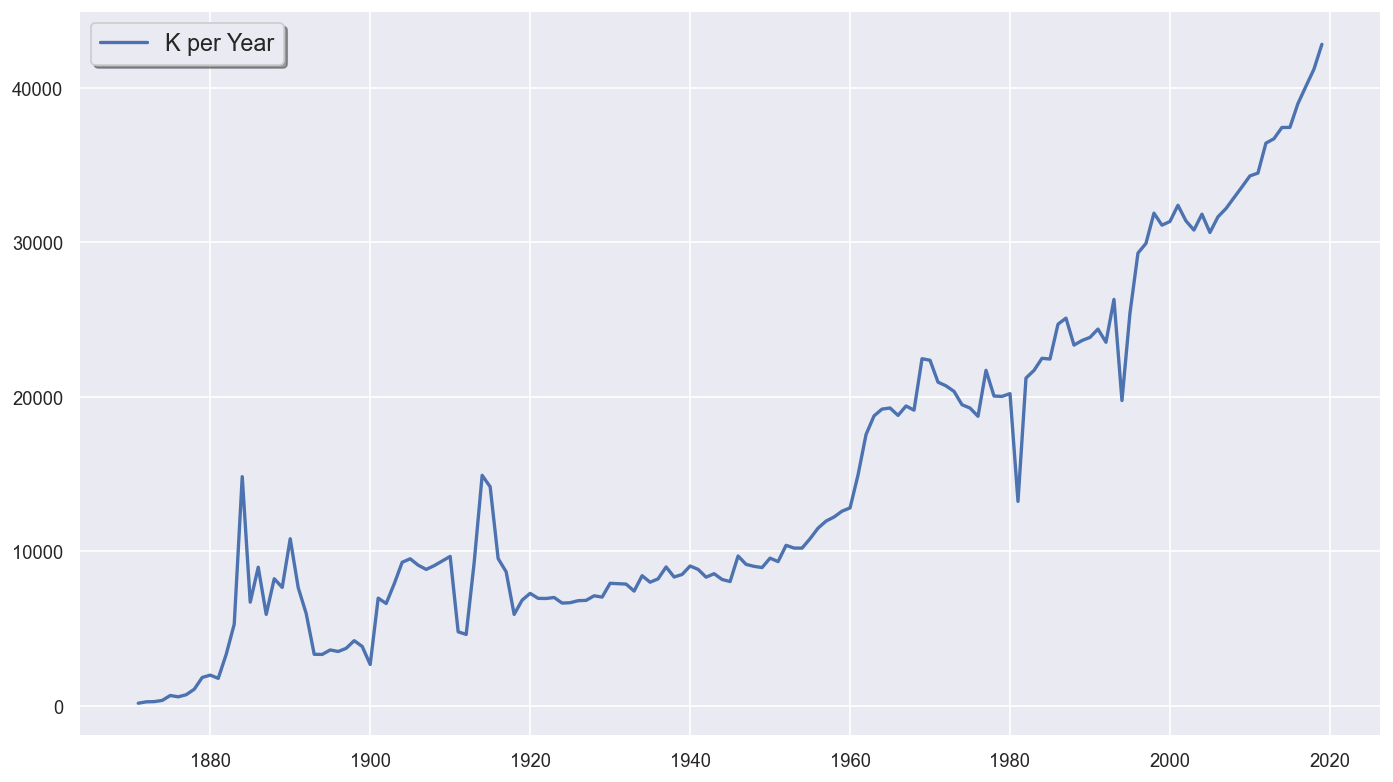

In [ ]:
ax = start_plot(style='darkgrid', figsize=(14, 8), dpi = 120)
ax.plot(so, label = 'K per Year', lw = 2)
so = mlb.groupby('yearID').sum()['SO']
hits = mlb.groupby('yearID').sum()['H']
ax.legend(shadow=True, fontsize = 14, loc = 'upper left')

In [ ]:
df2 = mlb[mlb['yearID'] > 1900]
df2.HBP.fillna(0, inplace=True)
df2.SF.fillna(0, inplace=True)

df2['PA'] = df2.AB + df2.BB + df2.SF + df2.HBP
pa = df2.groupby('yearID')['PA'].sum()
bb = df2.groupby('yearID')['BB'].sum()
so = df2.groupby('yearID')['SO'].sum()
stat = pd.DataFrame({'PA': pa, 'SO': so, 'BB': bb})
stat.head()

C:\Users\wonglab\.conda\envs\Q\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\wonglab\.conda\envs\Q\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


PA      SO      BB
yearID                         
1901    83400.0  6976.0  5465.0
1902    82438.0  6630.0  5442.0
1903    81535.0  7899.0  5367.0
1904    88842.0  9299.0  5576.0
1905    88849.0  9523.0  6189.0

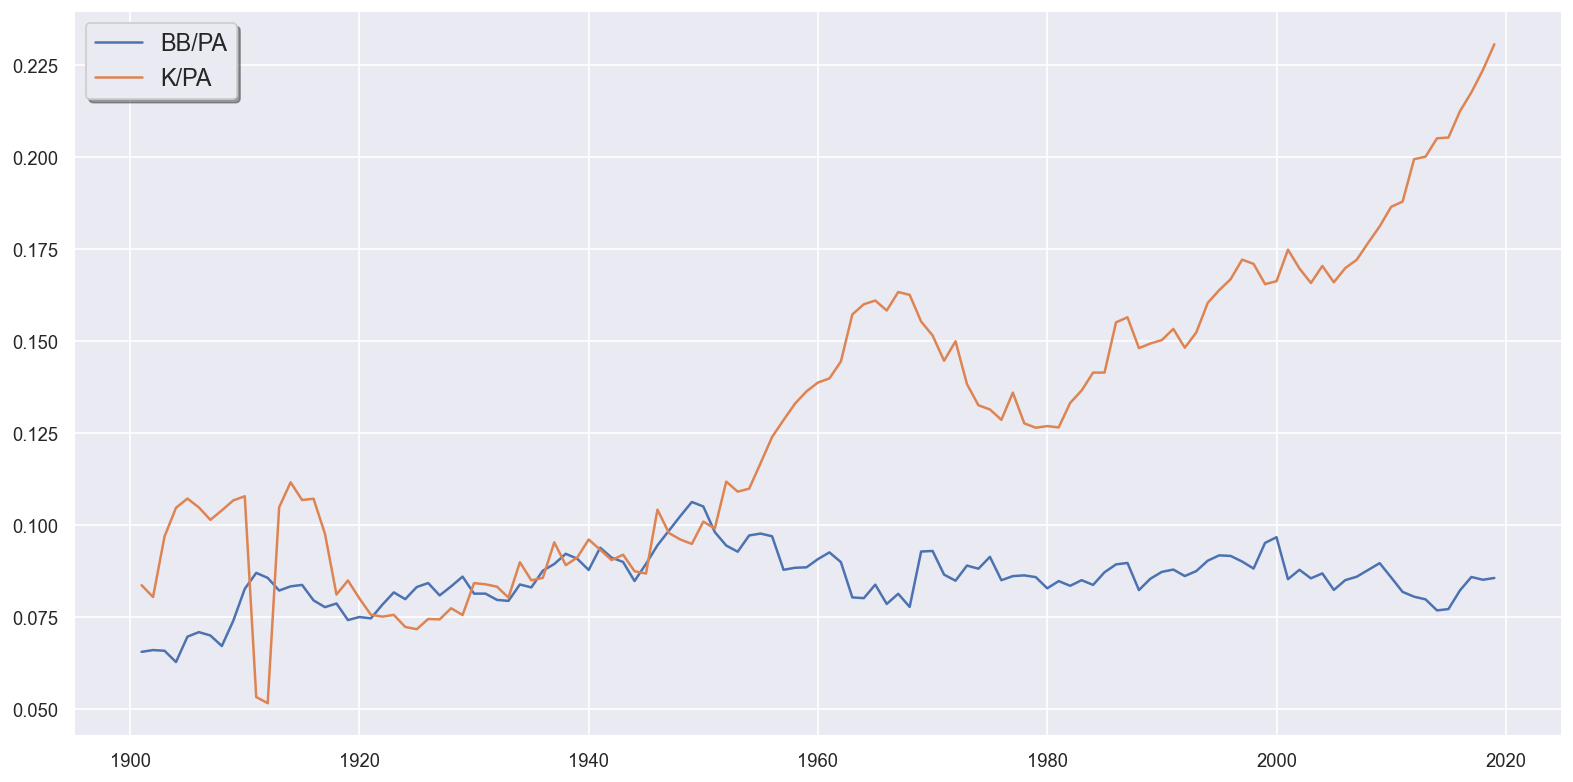

In [ ]:
ax = start_plot(figsize=(16, 8), style='darkgrid', dpi=120)
ax.plot(stat.BB / stat.PA, label='BB/PA')
ax.plot(stat.SO / stat.PA, label='K/PA')
ax.legend(shadow=True, fontsize=14)

# 如何分解時間序列

以下用 statsmodels 的 [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) 拆解時間序列元件，細節需參閱[例1](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)以及[例2](https://gist.github.com/balzer82/5cec6ad7adc1b550e7ee)， 例1的推薦的方法簡單，但是不好控制輸出的格式和品質，例2提供更多彈性以及更好的輸出品質。


```
推薦：以四個 ax object，分別處理 df， trend，seanonality, residuals，.plot() 四個子圖：

# te is the time-indexed dataframe 
res = seasonal_decompose(te, model = 'additive', period = 360)

fig, ax  = plt.subplots( 4, 1, figsize = (16, 10), sharex = True)

# plot the original data set, can be viewed as "observation" 
# subplot shown in origianl output
te.plot(ax = ax[0])

# trend part
res.trend.plot(ax=ax[1])
ax[1].legend(['Trend'])

# seasonal part
res.seasonal.plot(ax=ax[2])
ax[2].legend(['Seasonal'], loc = 'best')

#residuals part
res.resid.plot(ax=ax[3])
ax[3].legend(['Residuals'], loc = 'best')
ax[3].set_xlabel('whatever you want')
```

也可以使用 subplots(1, 1, figsize=(hsize, vsize)) 方式，只呈現四個子圖中其中一個，所以此法彈性較高。

In [ ]:
ice.head()

production
DATE                  
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636

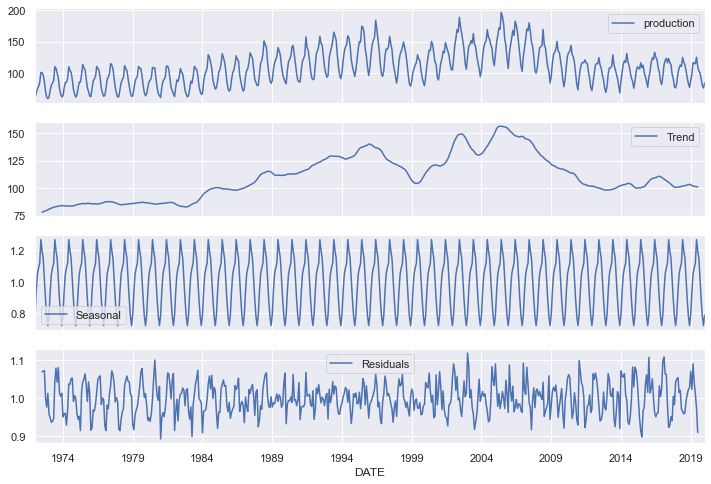

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

to_be_examined = ice
result = seasonal_decompose(to_be_examined, model='multiplicative')

fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
to_be_examined.plot(ax=ax[0])
result.trend.plot(ax=ax[1])
ax[1].legend(['Trend'], loc='best')
result.seasonal.plot(ax=ax[2])
ax[2].legend(['Seasonal'], loc='best')
result.resid.plot(ax=ax[3])
ax[3].legend(['Residuals'], loc='best')

# 用美股資料練習 Smoothing

載入美股資料，最常用的兩個套件是 pandas_datareader & yfiance，使用前記得確認這兩個套件已經安裝好

```
!pip3 install yfinance
!pip3 install pandas_datareader
```
- [pandas_datareader](https://pandas-datareader.readthedocs.io/en/latest/index.html)
- [yfinance](https://pypi.org/project/yfinance/)

##  pandas_datareader
[pandas_datareader](https://pandas-datareader.readthedocs.io/en/latest/)使用 python 標準函式庫的 [datetime](https://docs.python.org/3/library/datetime.html) class 指定起訖時間。範例如下：
```
import pandas_datareader.data as web
import datetime as dt
start = dt.datetime(2017,1,1)
end = dt.datetime.now() 
df = web.DataReader('GOOG', 'yahoo', start, end)
```

DataReader 下載的資料格式是 Pandas Dataframe, 的欄位包括 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close' 以及 Datetime 格式的索引 ‘Date'。

In [ ]:
import pandas_datareader.data as web
import datetime as dt

symbol = 'GOOG'
start_year, start_month, start_day = 2015, 1, 1
start = dt.datetime(start_year, start_month, start_day)
end = dt.datetime.now()
df = web.DataReader(symbol, 'yahoo', start, end)

In [ ]:
df.head()

High         Low        Open       Close     Volume  \
Date                                                                    
2014-12-31  531.141724  524.360352  529.795471  524.958740  1368246.0   
2015-01-02  529.815369  522.665039  527.561584  523.373108  1447563.0   
2015-01-05  522.894409  511.655243  521.827332  512.463013  2059840.0   
2015-01-06  514.761719  499.678131  513.589966  500.585632  2899940.0   
2015-01-07  505.855164  498.281952  505.611847  499.727997  2065054.0   

             Adj Close  
Date                    
2014-12-31  524.958740  
2015-01-02  523.373108  
2015-01-05  512.463013  
2015-01-06  500.585632  
2015-01-07  499.727997

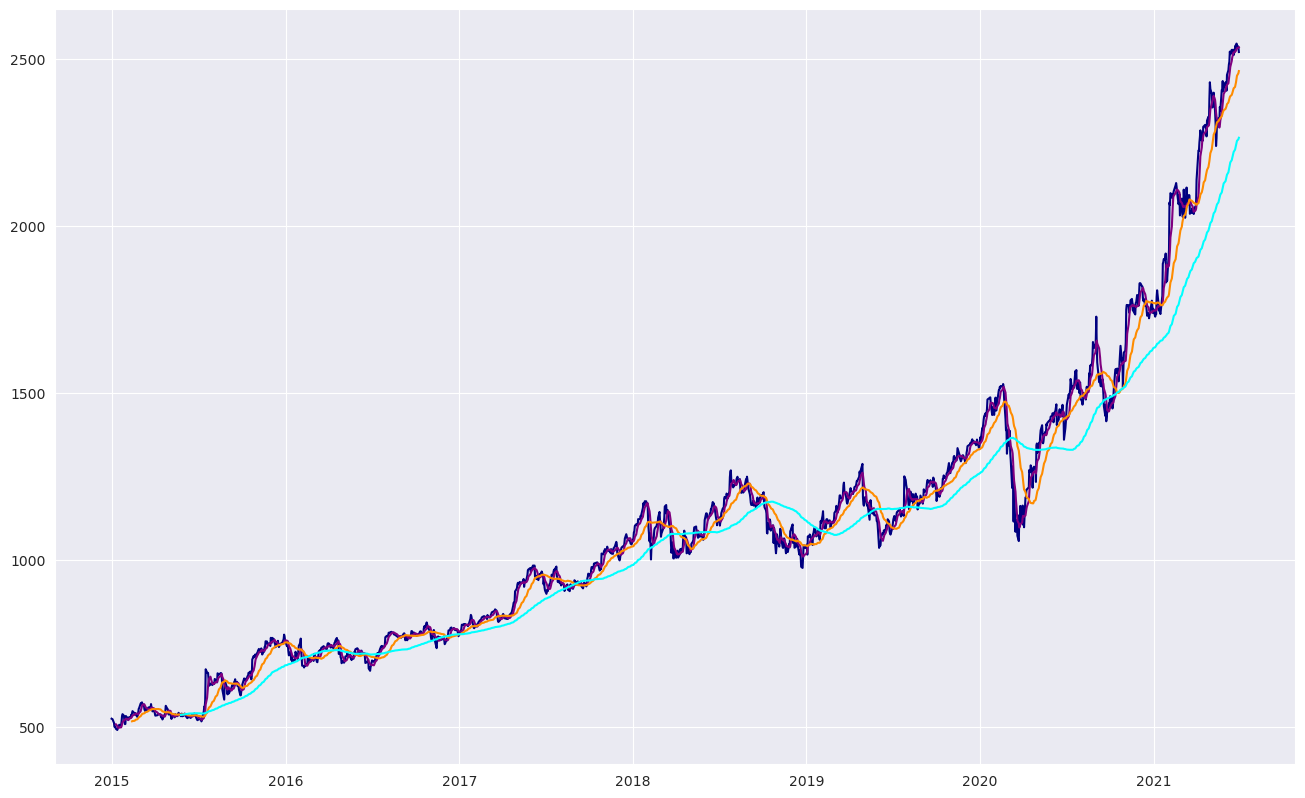

In [ ]:
ax = start_plot(figsize=(16, 10), style='darkgrid')
ax.plot(df.Close, c='navy')

## Smoothing
ax.plot(df.Close.rolling(window=7).mean(), c='purple')
ax.plot(df.Close.rolling(window=30).mean(), c='darkorange')
ax.plot(df.Close.rolling(window=100).mean(), c='cyan')

In [ ]:
%%time
symbols = ['IBM', 'AAPL', 'GOOG', 'NFLX']
start_year, start_month, start_day = 2015, 1, 1
start = dt.datetime(start_year, start_month, start_day)
end = dt.datetime.now()
dfs = web.DataReader(symbols, 'yahoo', start, end)

Wall time: 2.64 s


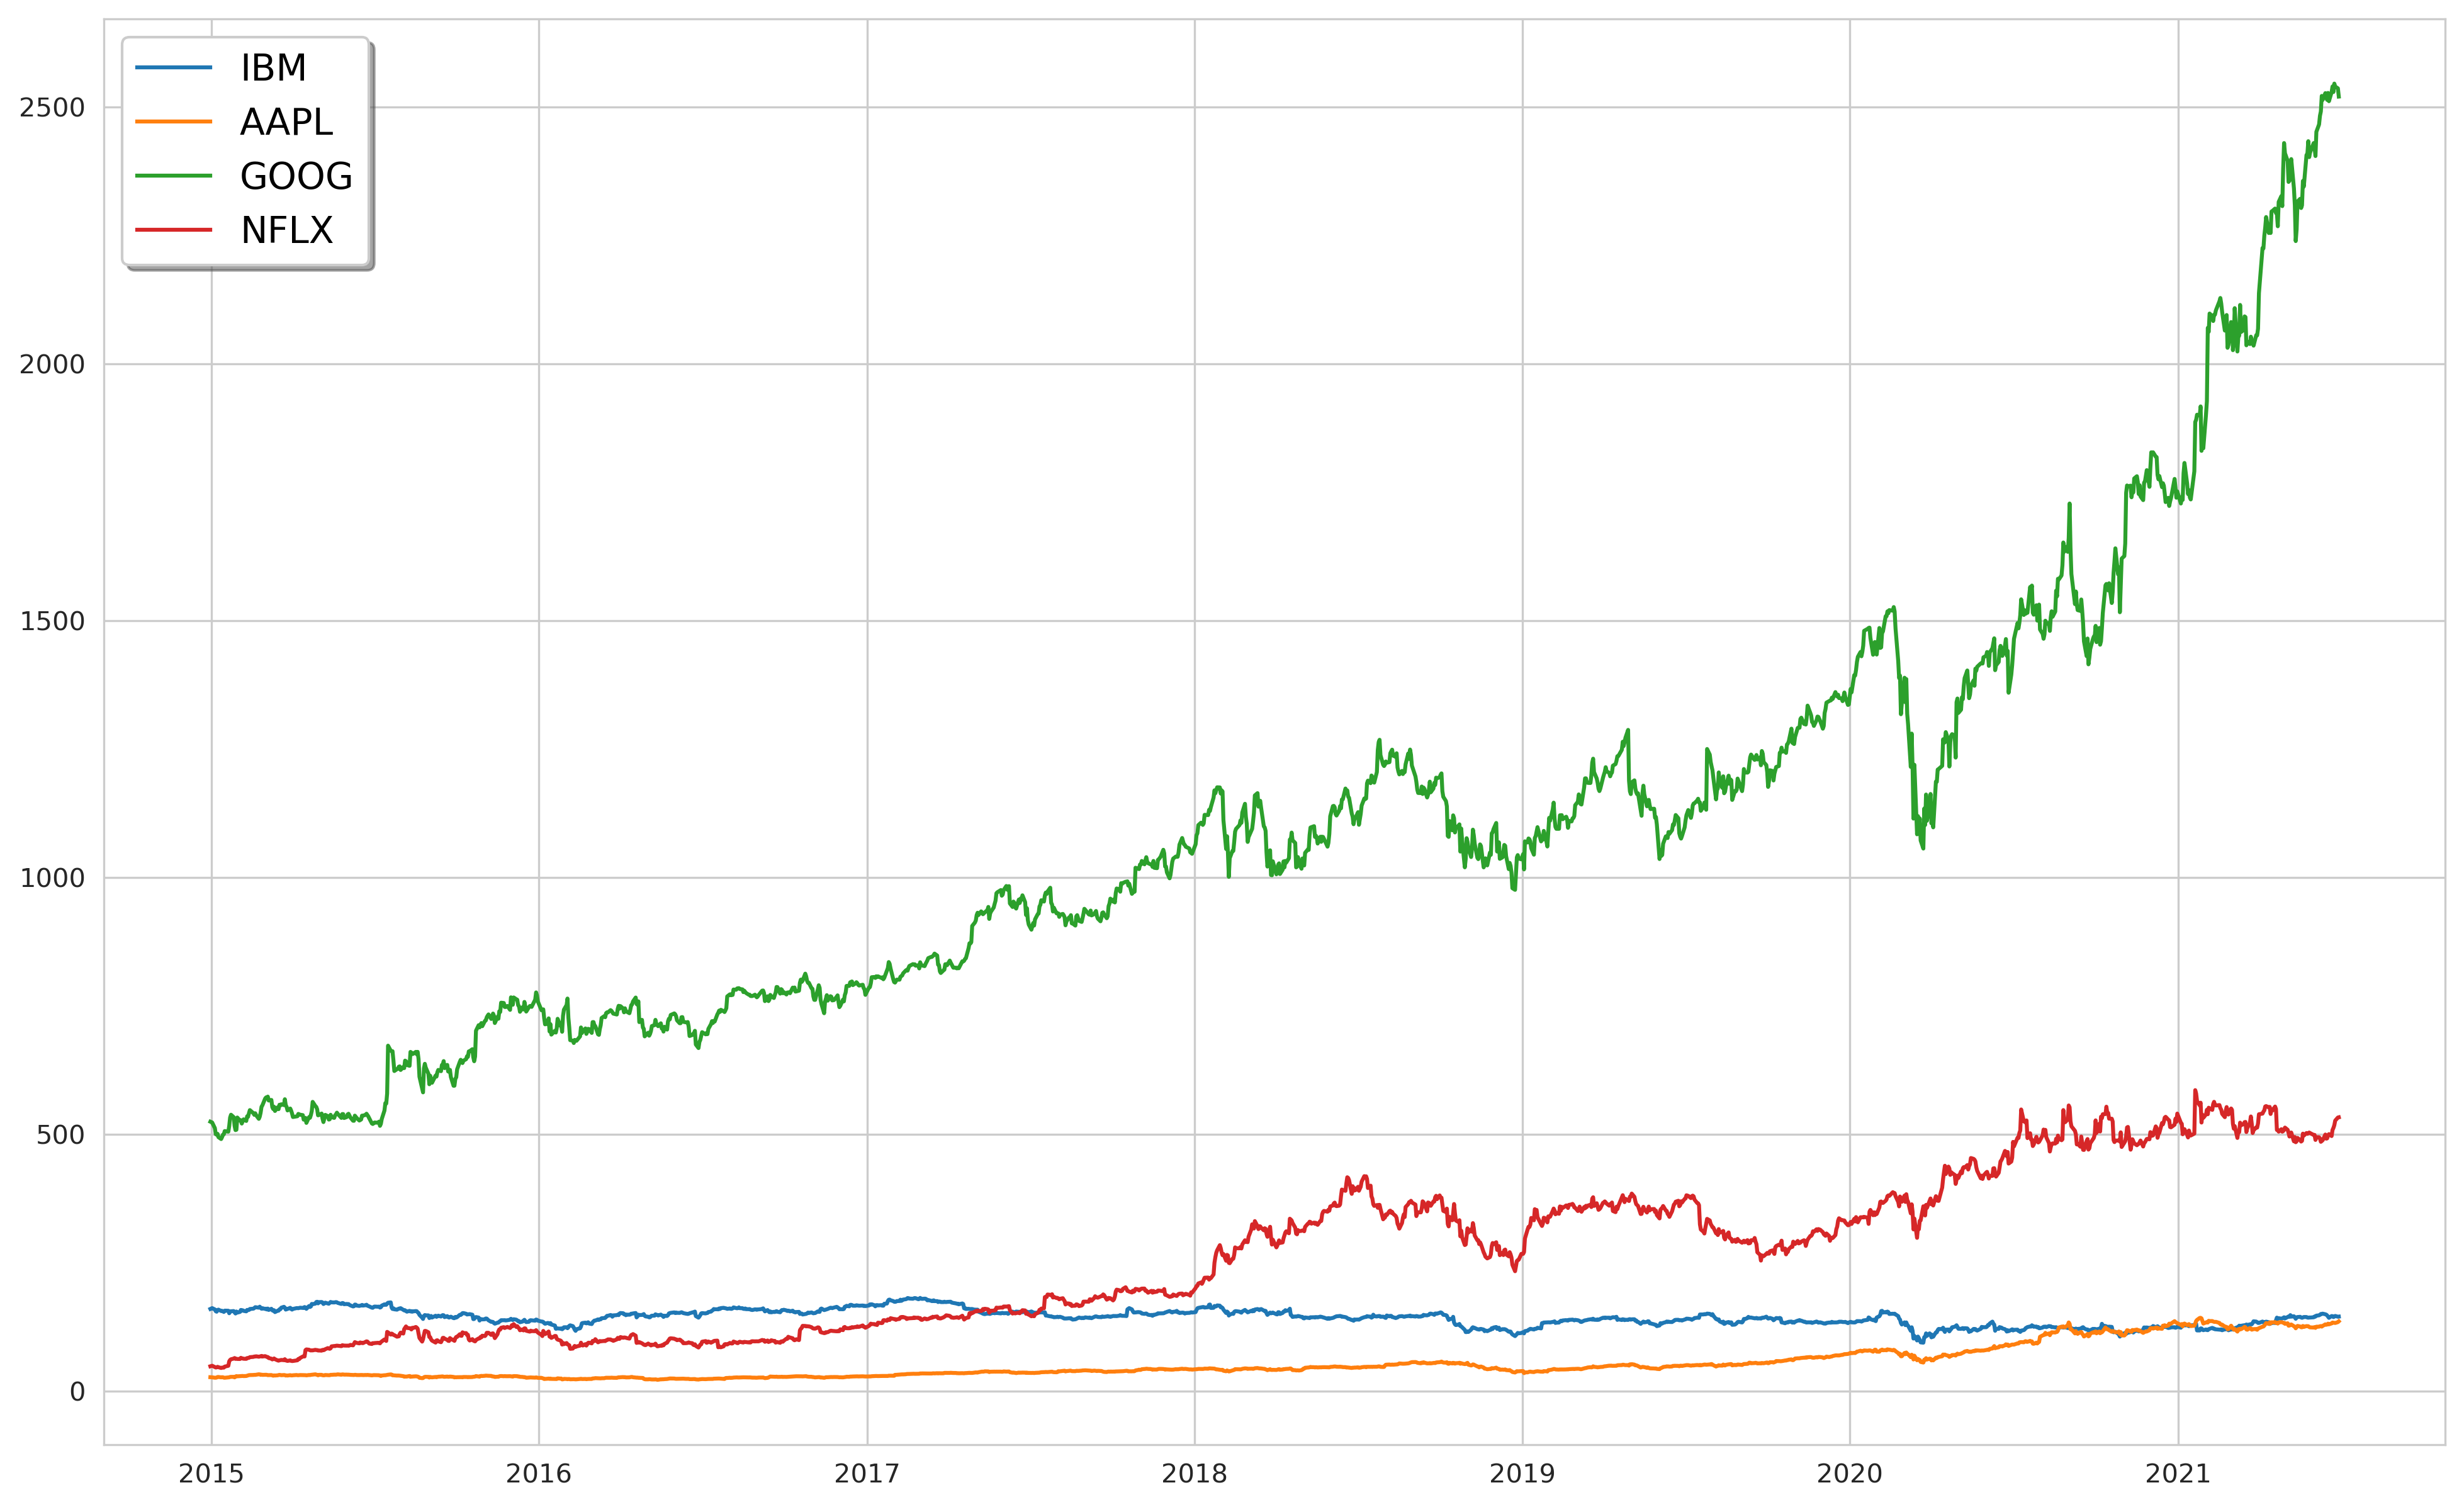

In [ ]:
ax = start_plot(figsize=(16, 10), dpi=300)

for x in symbols:
    ax.plot(dfs.Close[x], label=x)

ax.legend(shadow=True, fontsize=14)

### yfinance

In [ ]:
import yfinance as yf

msft = yf.Ticker('GOOG')
hist = msft.history(period='max')
hist.head()

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2004-08-19  49.813290  51.835709  47.800831  49.982655  44871361          0   
2004-08-20  50.316402  54.336334  50.062355  53.952770  22942874          0   
2004-08-23  55.168217  56.528118  54.321388  54.495735  18342897          0   
2004-08-24  55.412300  55.591629  51.591621  52.239197  15319808          0   
2004-08-25  52.284027  53.798351  51.746044  52.802086   9232276          0   

            Stock Splits  
Date                      
2004-08-19           0.0  
2004-08-20           0.0  
2004-08-23           0.0  
2004-08-24           0.0  
2004-08-25           0.0

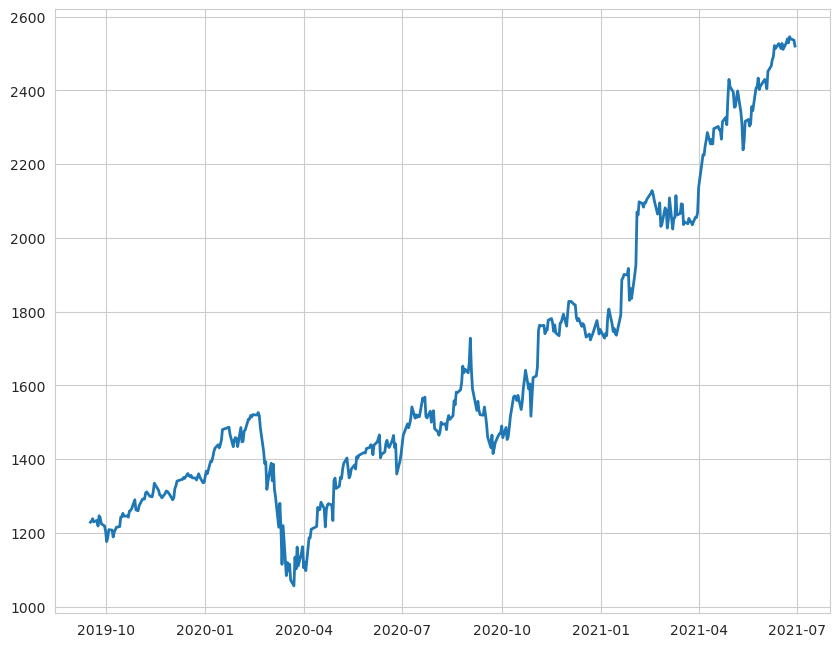

In [ ]:
ax = start_plot()
ax.plot(hist.index[-450:], hist.Close[-450:], lw=2)

## Exponentially weighted windows

- [Exponentially weighted windows](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#stats-moments-exponentially-weighted)
- [pandas.DataFrame.ewm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html)

- 用 [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html) 執行 [simple exponential smoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html)

- [Averaging and smoothing models](https://people.duke.edu/~rnau/411avg.htm)
- [Exponential Smoothing: Definition of Simple, Double and Triple](https://www.statisticshowto.datasciencecentral.com/exponential-smoothing/)
- [How to Build Exponential Smoothing Models Using Python](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1)
- [7.1 Simple exponential smoothing](https://otexts.com/fpp2/ses.html)


C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.

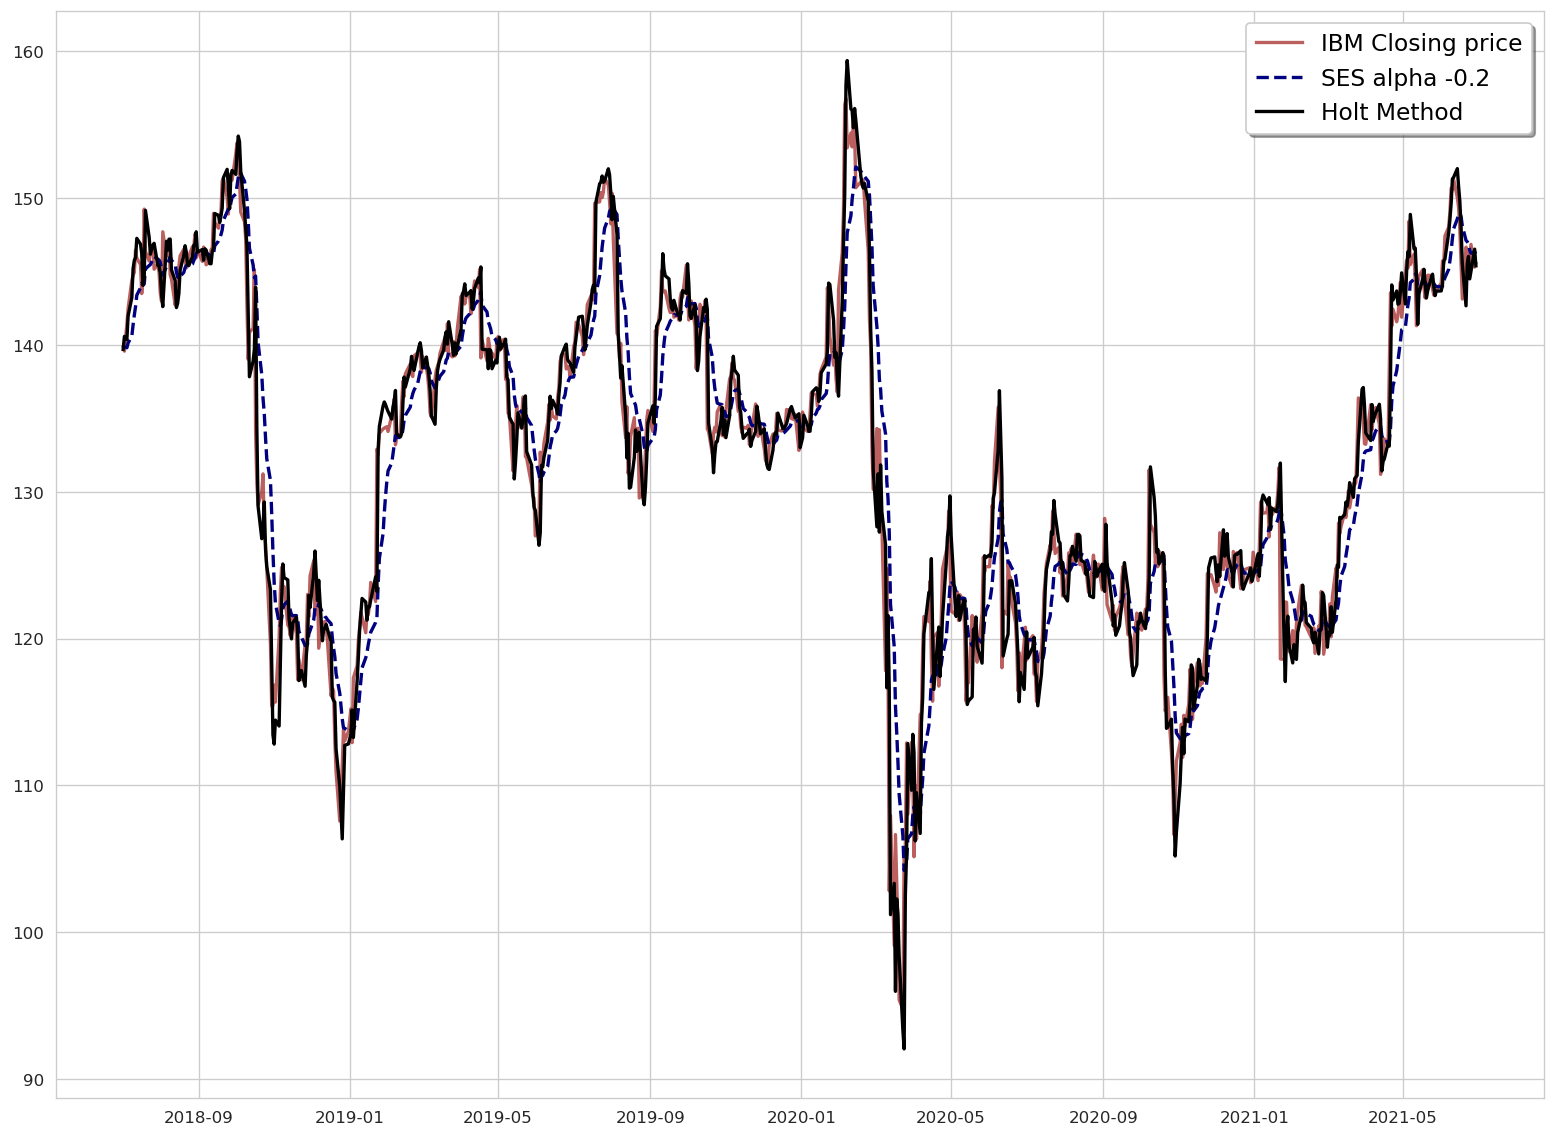

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

start_year, start_month = 2018, 7
symbol = 'IBM'

start = dt.datetime(start_year, start_month, 1)
end = dt.datetime.now()

df = web.DataReader(symbol, 'yahoo', start, end)

ax = start_plot(figsize=(16, 12), dpi=120)

fit2 = SimpleExpSmoothing(df.Close).fit(smoothing_level=0.2, optimized=False)
fit6 = SimpleExpSmoothing(df.Close).fit(smoothing_level=0.6, optimized=False)
holt1 = Holt(df.Close).fit(smoothing_level=0.8, smoothing_slope=0.2)

ax.plot(df.Close, c='brown', lw=2, alpha=0.75, label='%s Closing price' % symbol)
ax.plot(fit2.fittedvalues, c='navy', lw=2, ls='--', label='SES alpha -0.2')
ax.plot(holt1.fittedvalues, c='k', lw=2, label='Holt Method')
ax.legend(shadow=True, fontsize=14)

# ADF-Test

- [Augmented Dickey-Fuller Test in Python](https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

class StationarityTests:
    
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [ ]:
temp_csv = os.path.join(data_dir, 'daily-minimum-temperatures-in-me.csv')
melbourne = pd.read_csv(temp_csv, header=0, index_col=['Date'], parse_dates=['Date'], error_bad_lines=False)

b'Skipping line 3653: expected 2 fields, saw 3\n'


In [ ]:
air = pd.read_csv(os.path.join(data_dir, 'AirPassengers.csv'),
    index_col = 0, parse_dates = ['Month'])

Tester = StationarityTests()
Tester.ADF_Stationarity_Test(air, printResults=True)

print('------')
Tester.isStationary

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        0.815369
P-Value                   0.991880
# Lags Used              13.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64
------


False

In [ ]:
filepath = os.path.join(data_dir, 'ice_cream.csv')
ice = pd.read_csv(filepath, index_col = 0, 
    parse_dates=['DATE'])
ice.rename(columns={'IPN31152N':'production'}, inplace=True)

# Lag Plot

In [ ]:
filepath = os.path.join(data_dir, 'Amtrak data.csv')
data = pd.read_csv(filepath)
data = data.dropna()
date_rng = pd.date_range(start='1991-1-1', end='2004-4-1', freq='M')
amt = pd.DataFrame(index=date_rng, data=data.Ridership.values, columns=['Ridership'])

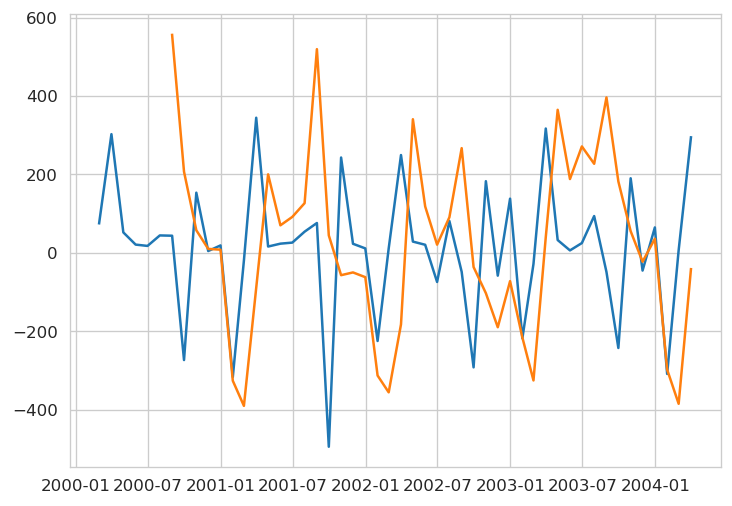

In [ ]:
ax = start_plot(figsize=(7, 5), dpi=120)
lag_num = 1
# ax.plot(amt.Ridership['2000-01-31':])
ax.plot(amt.Ridership['2000-01-31':].diff(lag_num))
ax.plot(amt.Ridership['2000-01-31':].diff(lag_num + 6))
# ax.plot(amt.Ridership['2000-01-31':].diff(lag_num + 2))

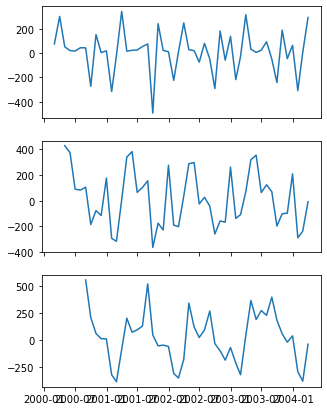

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(5, 7), sharex=True)

ax[0].plot(amt.Ridership['2000-01-31':].diff(lag_num))
ax[1].plot(amt.Ridership['2000-01-31':].diff(lag_num + 2))
ax[2].plot(amt.Ridership['2000-01-31':].diff(lag_num + 6))

# Plot ACF and PACF

pandas 和 statsmodels 都能夠畫 ACF 和 PACF，而且這兩個模組畫 ACF 的方式很簡單，只要輸入簡單的一維 X 陣列

參考資料：

- Pandas [autocorrelation_plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html?highlight=autocorrelation#pandas.plotting.autocorrelation_plot)
- statsmoels [plot_acf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) & [plot_pacf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html?highlight=plot_pacf#statsmodels.graphics.tsaplots.plot_pacf)
- [Time Series Analysis Tutorial with Python](https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332602034358&utm_targetid=aud-299261629574:dsa-473406571155&utm_loc_interest_ms=&utm_loc_physical_ms=21102&gclid=Cj0KCQiAyp7yBRCwARIsABfQsnSWrJdJVL935s4VtsqZnGIbgTJavvEo2jSdxtQeBUf57bkyj7X4PjYaArQBEALw_wcB)
- [Pandas Plotting Guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

In [ ]:
os.getcwd()

'C:\\Users\\wonglab\\GPR-UDCS'

In [ ]:
example = pd.read_excel('C:/Users/wonglab/Downloads/Cl-data.xlsx', header=None, index_col=None)
# example.rename(columns={0: "Cl"}, inplace=True)

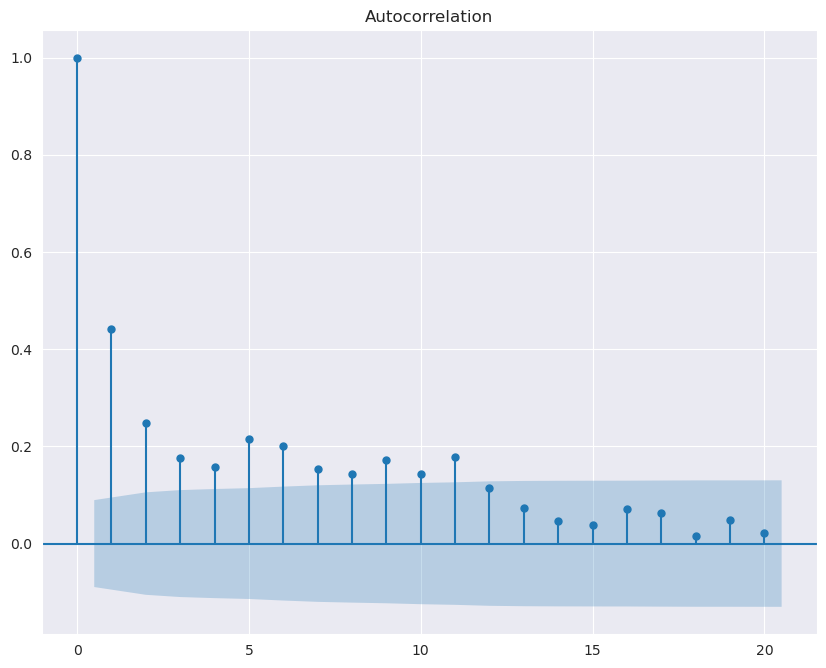

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ax = start_plot(style="darkgrid")
plot_acf(example.values.squeeze(), ax=ax, lags=20)
plt.show()

In [ ]:
%%time
from statsmodels.tsa.arima_model import ARMA

model = ARMA(example, order=(2, 0))
model = model.fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                     Cl   No. Observations:                  480
Model:                     ARMA(2, 0)   Log Likelihood               -1581.744
Method:                       css-mle   S.D. of innovations              6.528
Date:                Wed, 12 Jan 2022   AIC                           3171.489
Time:                        14:53:06   BIC                           3188.184
Sample:                             0   HQIC                          3178.051
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1732      0.570     33.643      0.000      18.056      20.290
ar.L1.Cl       0.4104      0.045      9.022      0.000       0.321       0.500
ar.L2.Cl       0.0679      0.046      1.491      0.1

C:\Users\wonglab\anaconda3\envs\ENV_1\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


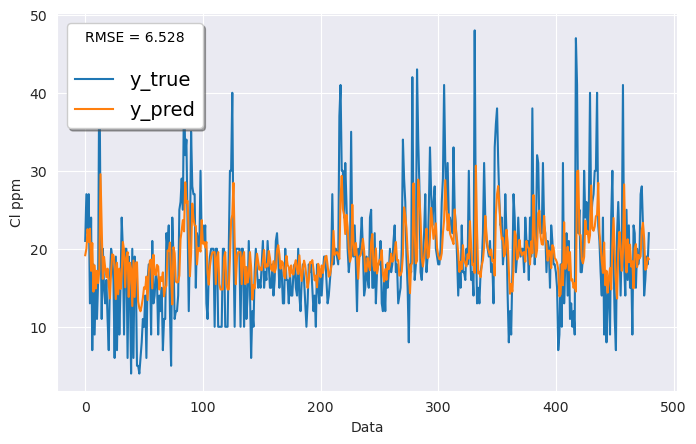

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict()
mse = mean_squared_error(example, y_pred)
rmse = np.sqrt(mse)
ax = start_plot(figsize=(8,5), style='darkgrid')
ax.plot(example, label = 'y_true')
ax.plot(y_pred, label = 'y_pred')
ax.set_xlabel('Data')
ax.set_ylabel('Cl ppm')
ax.legend( title = 'RMSE = %.3f\n' %rmse,
    shadow=True,fontsize=14,loc='best')

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

filepath = os.path.join(data_dir, 'ice_cream.csv')
ice = pd.read_csv(filepath, index_col = 0, 
    parse_dates=['DATE'])
ice.rename(columns={'IPN31152N':'production'}, inplace=True)

ice = ice['2010-01-01':]

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

autocorrelation_plot(ice, ax=ax[0])
ax[0].set_title('ACF produced by pandas')
ax[0].set_xlabel(' \n \n')
plot_acf(ice, ax=ax[1], lags=120)
ax[1].set_title('ACF Plot produced by statsmodels')

C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


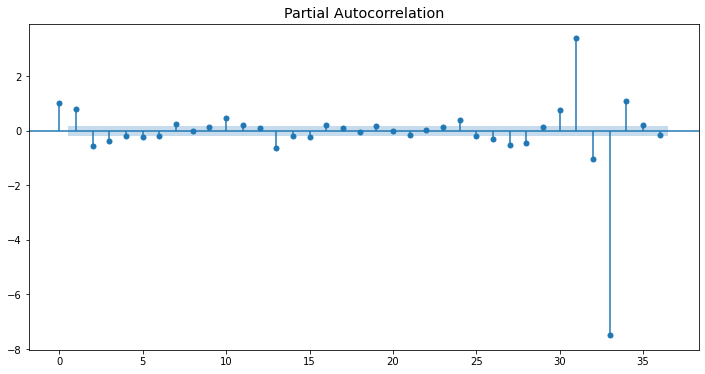

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_pacf(ice, ax=ax, lags=36)
plt.show()

# AR, MA, ARMA 範例


以下幾個資料檔案都是由 YouTube Channel  [ritvikmath](http://ritvikmath.com/) 的[時間序列](https://www.youtube.com/watch?v=DeORzP0go5I&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3)教學例子中取出，重新製作，以下幾個例子供大家參考。

## AR Model

In [ ]:
filepath = os.path.join(data_dir, 'ice_cream.csv')
df = pd.read_csv(filepath, index_col = 0, parse_dates=['DATE'])
df.rename(columns={'IPN31152N':'production'}, inplace=True)
df.head()

production
DATE                  
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636

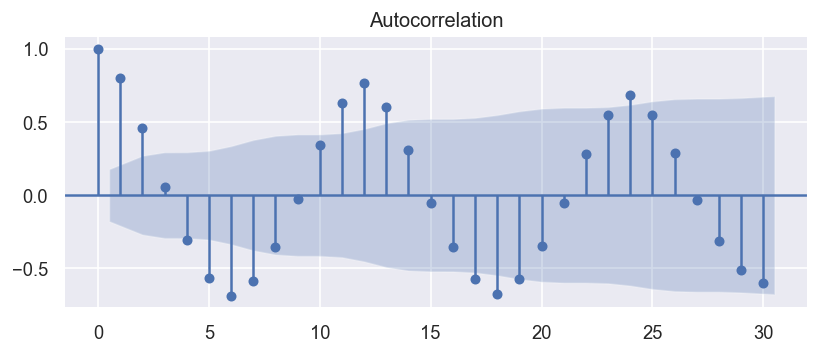

In [ ]:
# from pandas.plotting import plot_acf
df21 = df['2010-01-01':]
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,ax = plt.subplots(figsize=(8, 3), dpi = 120)
plot_acf(df21.values.squeeze(), lags = 30, ax = ax)
plt.show()

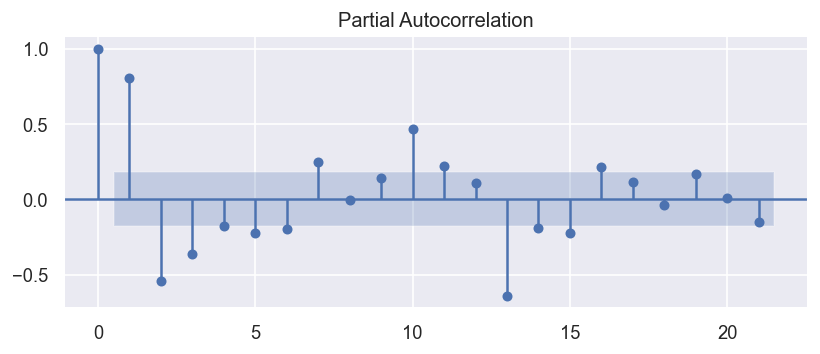

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,ax = plt.subplots(figsize=(8, 3), dpi = 120)
plot_pacf(df21, ax = ax)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARMA

train_df = df21[:'2018-12-01']
test_df = df21['2019-01-01':'2019-12-01']

In [ ]:
%%time
model = ARMA(train_df, order=(3,0))
model = model.fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                  108
Model:                     ARMA(3, 0)   Log Likelihood                -374.085
Method:                       css-mle   S.D. of innovations              7.642
Date:                Wed, 30 Jun 2021   AIC                            758.170
Time:                        13:40:43   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5743      1.809     57.265      0.000     100.029     107.119
ar.L1.production     1.0469      0.088     11.960      0.000       0.875       1.218
ar.L2.production    -0.0523 

C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred fre

In [ ]:
y_pred = model.predict(start='2019-01-01', end = '2019-12-01')

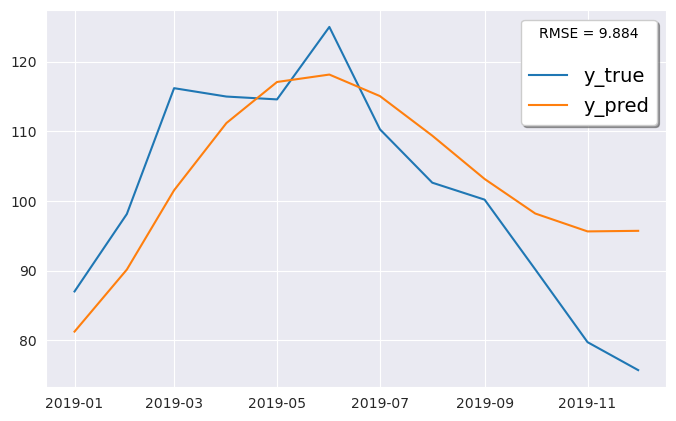

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_df.production, y_pred)
rmse = np.sqrt(mse)
ax = start_plot(figsize=(8,5), style='darkgrid')
ax.plot(test_df.production, label = 'y_true')
ax.plot(y_pred, label = 'y_pred')
ax.legend( title = 'RMSE = %.3f\n' %rmse,
    shadow=True,fontsize=14,loc='best')

## MA Model

$y_t = 50+0.4\times \epsilon_{t-1} + 0. 3\times \epsilon_{t-2} + \epsilon_t$

$\epsilon_t \sim [0,1]$

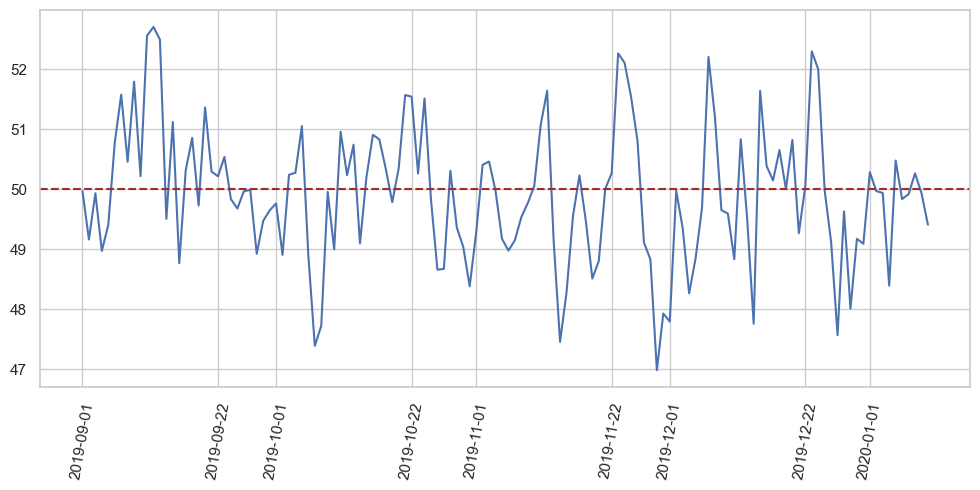

In [ ]:
errors = np.random.normal(0, 1, 400)
start_date, end_date ='2019-9-1', '2020-1-10'
date_index = pd.date_range(start=start_date, end=end_date)
mu = 50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

ax = start_plot(figsize=(12, 5))
ax.plot(date_index, series)
ax.axhline(y = mu, c = 'brown', ls = '--') 
ax.tick_params(axis='x', rotation = 80)

# Amtrak Prediction


投影片裏面的參考連結：

- https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms
- https://otexts.com/fpp2/non-seasonal-arima.html
- https://people.duke.edu/~rnau/411arim3.htm

In [ ]:
filepath = os.path.join(data_dir, 'Amtrak data.csv')
data = pd.read_csv(filepath)
data = data.dropna()
date_rng = pd.date_range(start='1991-1-1', end='2004-4-1', freq='M')
amt = pd.DataFrame(index = date_rng, data = data.Ridership.values, 
    columns = ['Ridership'])

## Decomposing Amtrak

Wall time: 248 ms


<AxesSubplot:>

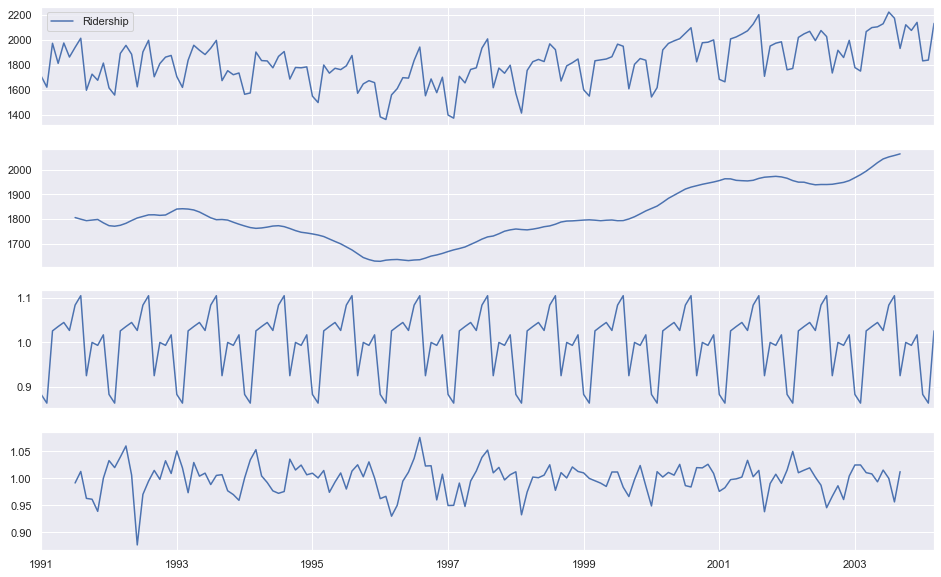

In [ ]:
%%time
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(4, 1, figsize=(16, 10), sharex=True)
examined = amt

decomposed = seasonal_decompose(examined, model='multiplicative')
examined.plot(ax=ax[0])
decomposed.trend.plot(ax=ax[1])
decomposed.seasonal.plot(ax=ax[2])
decomposed.resid.plot(ax=ax[3])

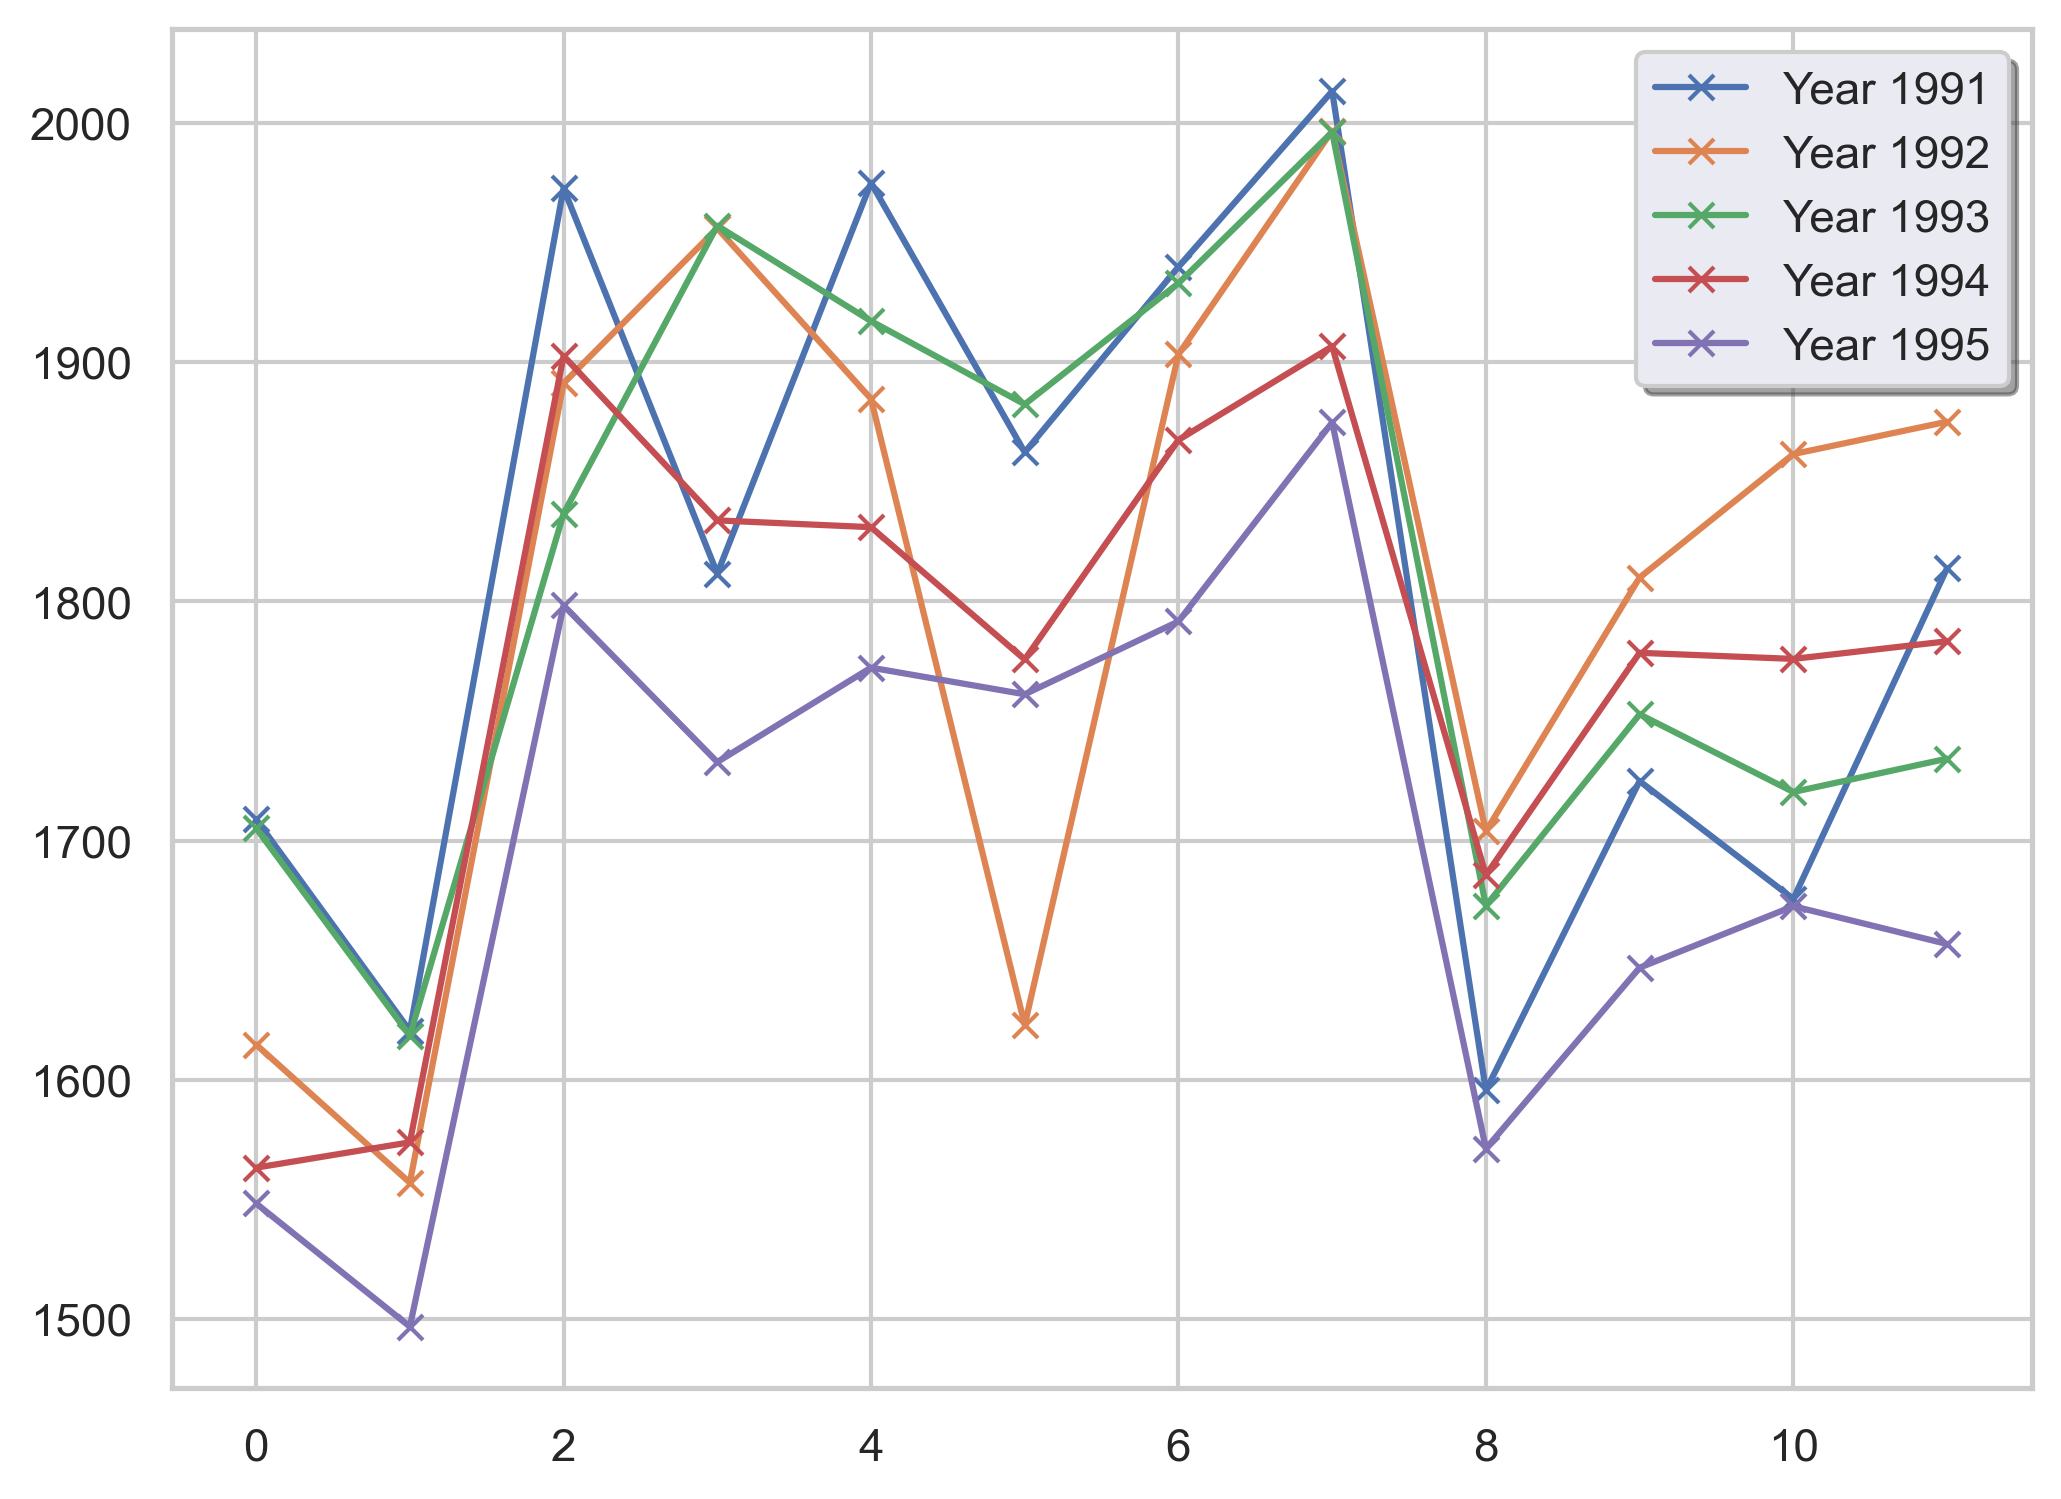

In [ ]:
a = amt.groupby([amt.index.year, amt.index.month]).sum()['Ridership']
ax = start_plot(figsize=(8, 6), dpi=300)
for y in range(1991, 1996):
    b = a[y].reset_index()
    ax.plot(b.index, b['Ridership'], marker='x', label= 'Year %d' % y)
    ax.legend(shadow=True)

## Lag

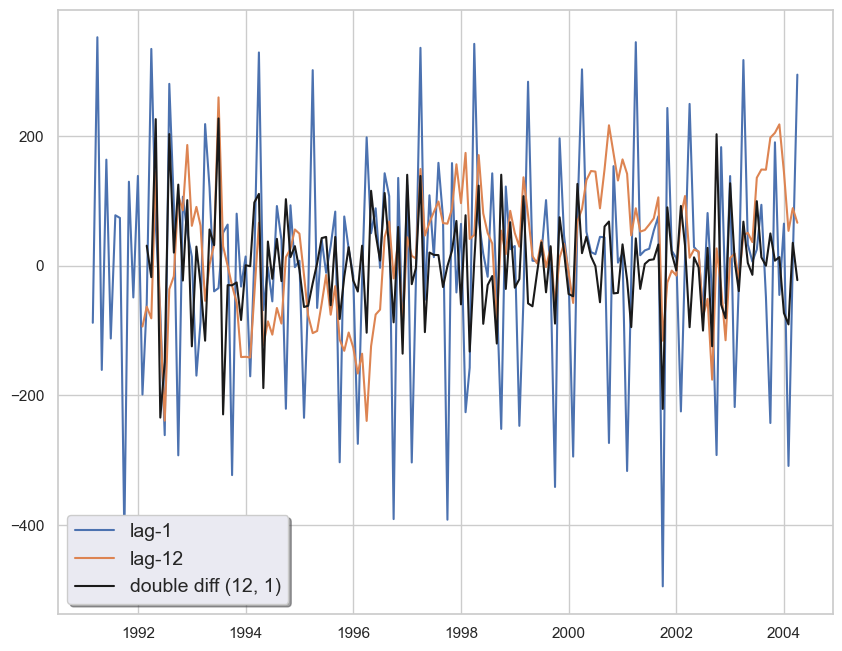

In [ ]:
ax = start_plot()
ax.plot(amt.Ridership.diff(1), label='lag-1')
ax.plot(amt.Ridership.diff(12), label='lag-12')
ax.plot(amt.Ridership.diff(12).diff(1), c='k', label='double diff (12, 1)')
ax.legend(shadow=True, fontsize=14)

## Polynomial Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score

def PolynomialRegression(X, y, deg = 3 ):

    the_model = make_pipeline(PolynomialFeatures(deg), 
        LinearRegression())

    the_model.fit(X, y)
    # if xdomain is None:
    #     xdomain = np.linspace( min(X.flatten()), max(X.flatten()), 00 ).reshape(-1, 1)
    fittedvalues = the_model.predict(X)
    return the_model, fittedvalues, r2_score(y, the_model.predict(X))


In [ ]:
from sklearn.linear_model import LinearRegression

degs = 50

X = np.arange(0, len(amt), 1).reshape(-1, 1)
y = np.array(amt.Ridership).reshape(-1, 1)

poly_model, y_pred, r2 = PolynomialRegression(X, y, deg=degs)

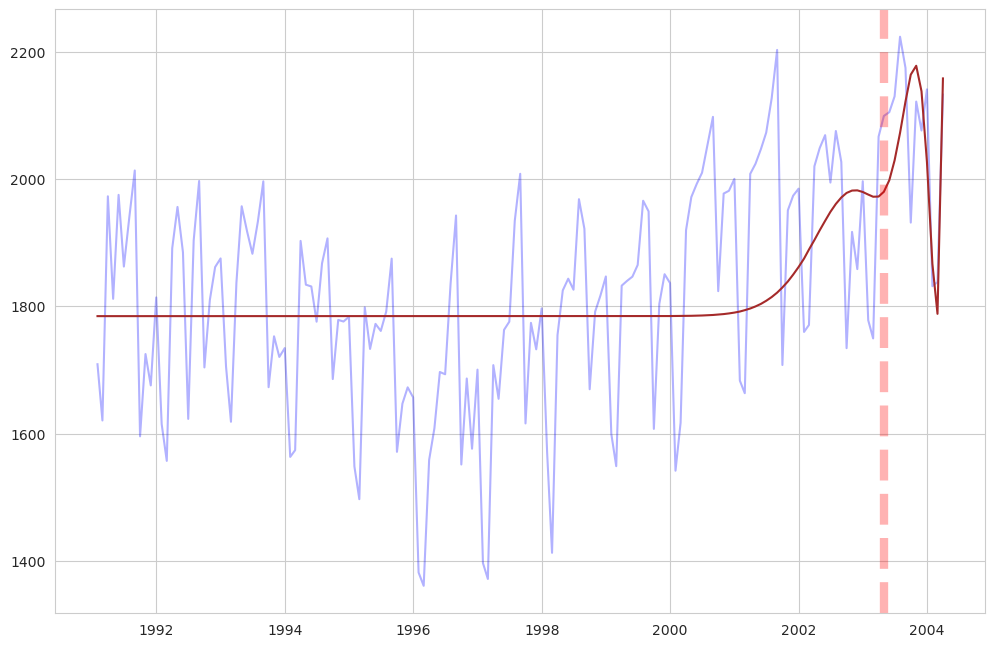

In [ ]:
ax = start_plot(figsize=(12, 8))
ax.plot(amt.Ridership, c='blue', alpha=0.3)
ax.plot(amt.index, y_pred, c='brown')
ax.axvline(x=amt.index[-12], lw=6, c='red', alpha=0.3, ls='--')## 分隔train & test


## ACF and PACF

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

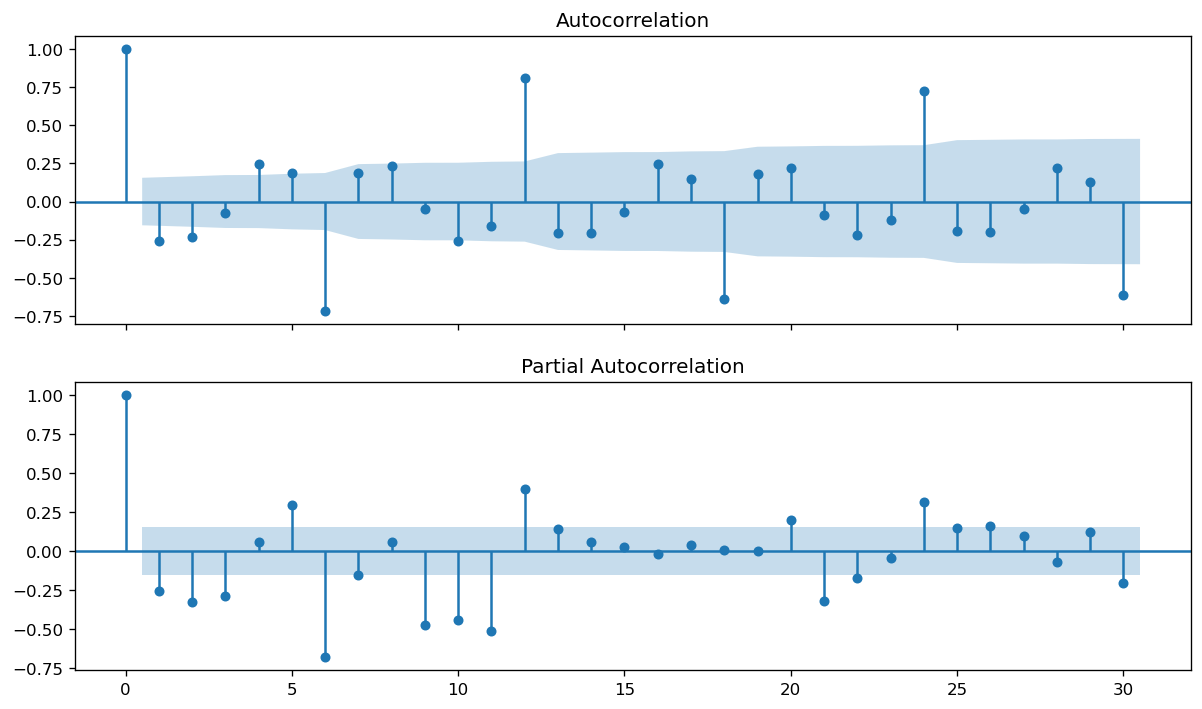

In [ ]:
lag1 = amt.Ridership.diff(1)[1:]

fig, ax = plt.subplots(2, 1, figsize=(12, 7), dpi=120, sharex=True)
plot_acf(lag1, lags=30, ax=ax[0])
plot_pacf(lag1, lags=30, ax=ax[1])
plt.show()

### Lag-1, AR-6

In [ ]:
edf = amt.diff(1)[1:]

train_df = edf[:'2003-3-31']
test_df = edf['2003-4-30':]

In [ ]:
%%time
model = ARMA(train_df, order=(6, 0))
model = model.fit()
print(model.summary())

C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:              Ridership   No. Observations:                  146
Model:                     ARMA(6, 0)   Log Likelihood                -883.146
Method:                       css-mle   S.D. of innovations            100.704
Date:                Thu, 10 Jun 2021   AIC                           1782.293
Time:                        13:00:41   BIC                           1806.162
Sample:                    02-28-1991   HQIC                          1791.991
                         - 03-31-2003                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7138      3.534      0.202      0.840      -6.212       7.640
ar.L1.Ridership    -0.2381      0.058     -4.087      0.000      -0.352      -0.124
ar.L2.Ridership    -0.1936      

In [ ]:
y_pred = model.predict(start='2003-4-30', end='2004-3-31')

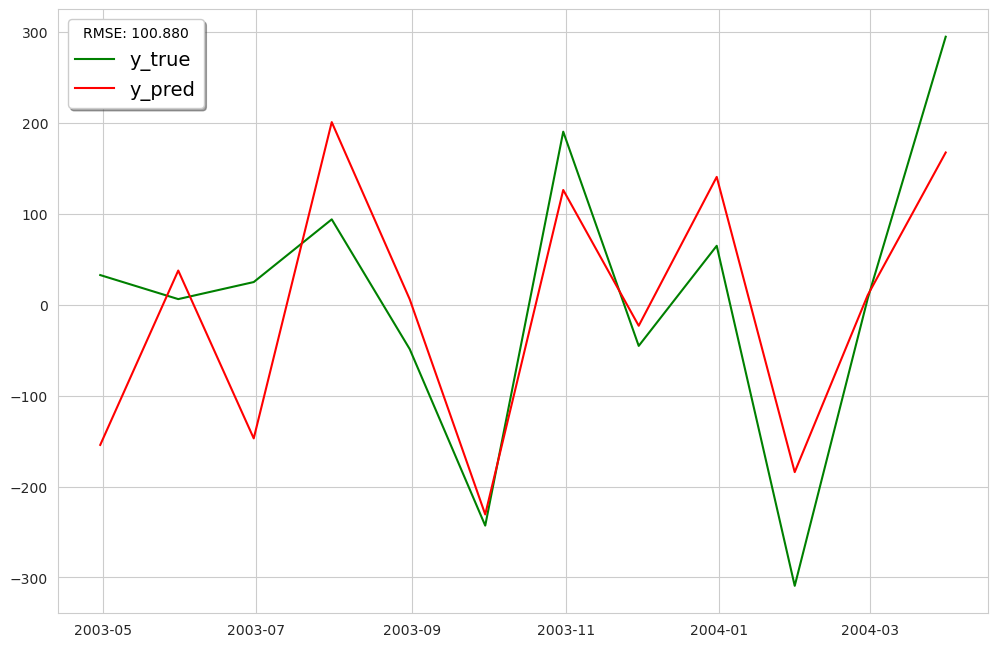

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_df.Ridership, y_pred)
rmse = np.sqrt(mse)

ax = start_plot(figsize=(12, 8))

ax.plot(test_df.Ridership, c='g', label='y_true')
ax.plot(test_df.index, y_pred, c='red', label='y_pred')
ax.legend(title='RMSE: %.3f' % rmse, shadow=True, fontsize=14)

### Lag(12, 1), ARIMA(12, 0, 3)

- (3,0,4)
- (4,0,1) 
- (12,0,3)

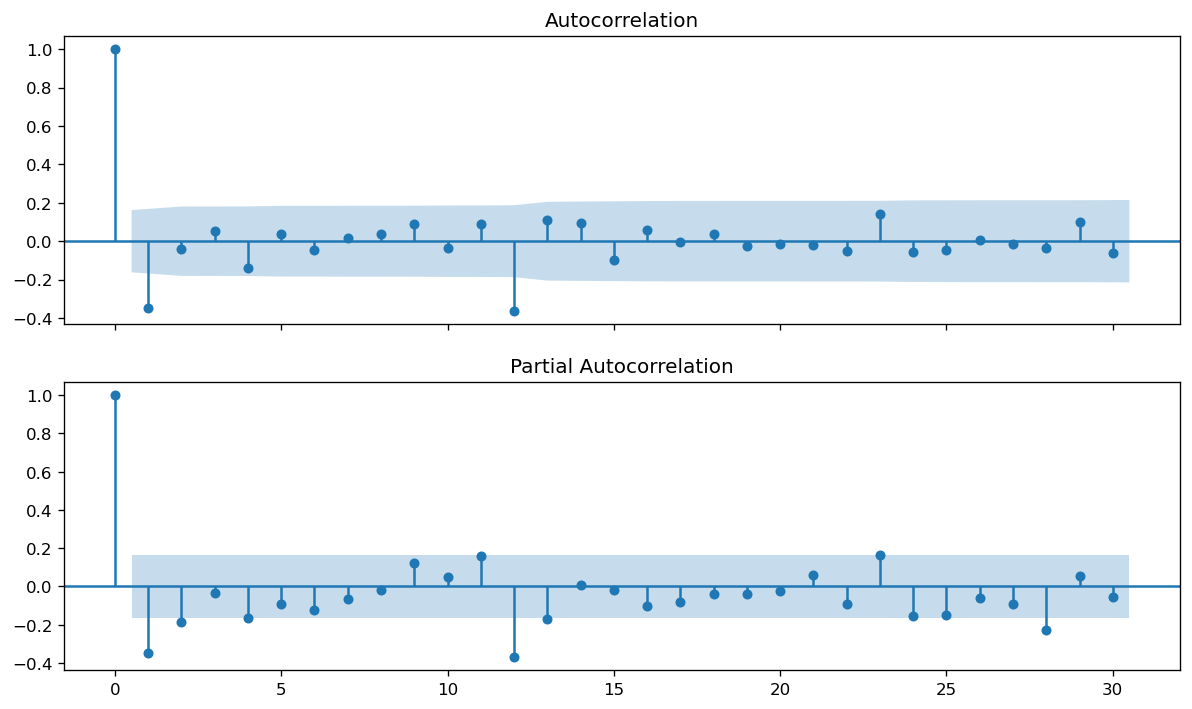

In [ ]:
lag121 = amt.Ridership.diff(12).diff(1)[13:]

fig, ax = plt.subplots(2, 1, figsize=(12, 7), dpi=120, sharex=True)
plot_acf(lag121, lags=30, ax=ax[0])
plot_pacf(lag121, lags=30, ax=ax[1])
plt.show()

3 & 12 值得去重視

ARIMA(12, 0, 3)

In [ ]:
edf = amt.diff(12).diff(1)[13:]

train_df = edf[:'2003-3-31']
test_df = edf['2003-4-30':]

In [ ]:
%%time

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_df, order=(12, 0, 3))
model = model.fit()
print(model.summary())

C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:              Ridership   No. Observations:                  134
Model:                    ARMA(12, 3)   Log Likelihood                -750.230
Method:                       css-mle   S.D. of innovations             63.620
Date:                Thu, 10 Jun 2021   AIC                           1534.460
Time:                        13:26:10   BIC                           1583.723
Sample:                    02-29-1992   HQIC                          1554.479
                         - 03-31-2003                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8844      0.383      2.310      0.021       0.134       1.635
ar.L1.Ridership      0.0398      0.176      0.226      0.821      -0.305       0.385
ar.L2.Ridership     -0.0943 

48.5376370940196

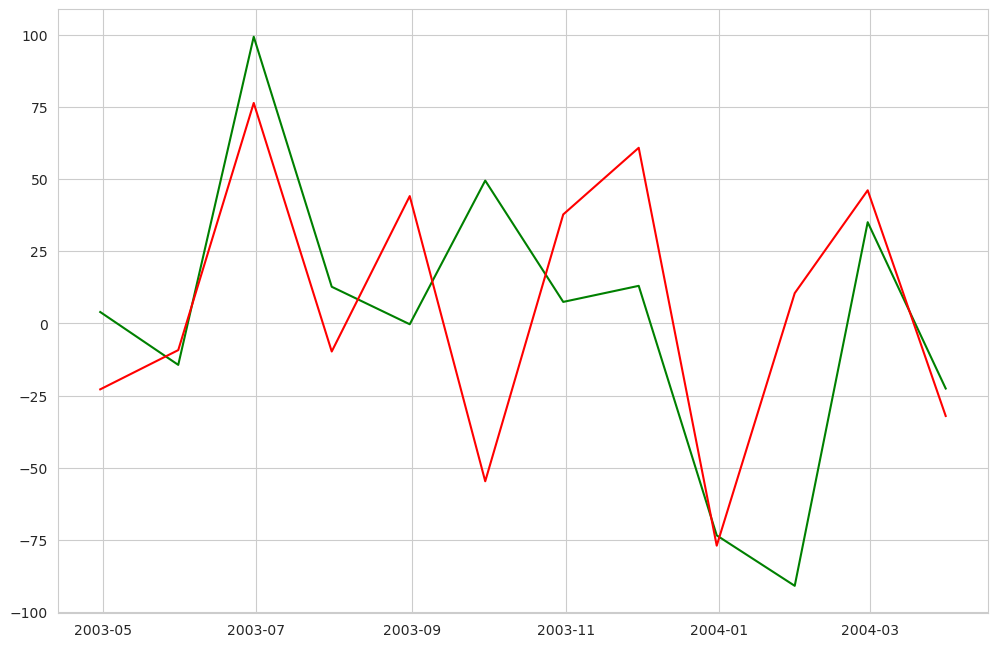

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(start='2003-04-30', end='2004-03-31')
ax = start_plot(figsize=(12, 8))
ax.plot(test_df.Ridership, c='g')
ax.plot(test_df.index, y_pred, c='red')
rmse = np.sqrt(mean_squared_error(test_df.Ridership, y_pred))
rmse

### Auto-Arima

In [ ]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

model_autoARIMA = auto_arima(edf.Ridership, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1700.051, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1683.431, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1676.745, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1676.607, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1674.344, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1680.573, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1675.420, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1675.800, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1674.384, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1682.401, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1671.319, Time=0.32 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1673.386, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1672.148, Time=0.26 sec
 ARIMA(4,0,1)(0,0,0)[0]             : 

# Storefornt Sales Prediction

In [ ]:
fetch_file_via_requests(
    DropboxLink('llhpyhb5vk5yv6v','test_store_17_final.csv' ), 
    data_dir)

fetch_file_via_requests(
    DropboxLink('oi1m5sqo78uej2m','train_store_17_final.csv' ), 
    data_dir)

'C:\\Users\\wonglab/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/tiempo/train_store_17_final.csv'

訓練資料集的時間範圍是 **2008-2-8 到 2012-1-27**，測試資料集的時間範圍是 **2012-2-3 到 2012-10-26**

In [ ]:
training_file = 'train_store_17_final.csv'
test_file = 'test_store_17_final.csv'
csv_training = os.path.join(data_dir, 'train_store_17_final.csv')
csv_test = os.path.join(data_dir, 'test_store_17_final.csv')


In [ ]:
df = pd.read_csv(csv_training, parse_dates=['Date'], index_col='Date')
df.head()

Store  Product  Weekly_Sales  IsHoliday    Campaign1  Campaign2  \
Date                                                                          
2008-02-08      1       17         22091      False  22633.78047        NaN   
2008-02-15      1       17         22089       True  22462.02858        NaN   
2008-02-22      1       17         22296      False  22896.25604        NaN   
2008-02-29      1       17         22353      False  23230.50116        NaN   
2008-03-07      1       17         22343      False  22785.00150        NaN   

            Campaign3  Campaign4  Campaign5         CPI  Unemployment  
Date                                                                   
2008-02-08        NaN        NaN        NaN  211.096358         8.106  
2008-02-15        NaN        NaN        NaN  211.242170         8.106  
2008-02-22        NaN        NaN        NaN  211.289143         8.106  
2008-02-29        NaN        NaN        NaN  211.319643         8.106  
2008-03-07        NaN        NaN        NaN  211.350143         8.106

In [ ]:
df.groupby([df.index.year, df.index.month]).sum()['Weekly_Sales']

Date  Date
2008  2        88829
      3        89292
      4        88219
      5       111028
      6        89075
      7        88590
      8       110862
      9        88631
      10      110493
      11       88954
      12       88200
2009  1       111392
      2        88956
      3        88821
      4        88973
      5       110327
      6        88153
      7       111092
      8        88969
      9        88896
      10      110784
      11       87995
      12       89234
2010  1       111510
      2        88829
      3        89292
      4       110084
      5        89163
      6        89075
      7       110717
      8        88735
      9        88631
      10      110493
      11       88954
      12      110130
2011  1        89462
      2        88956
      3        88821
      4       111095
      5        88205
      6        88153
      7       111092
      8        88969
      9       111113
      10       88567
      11       87995
      12      111660
20

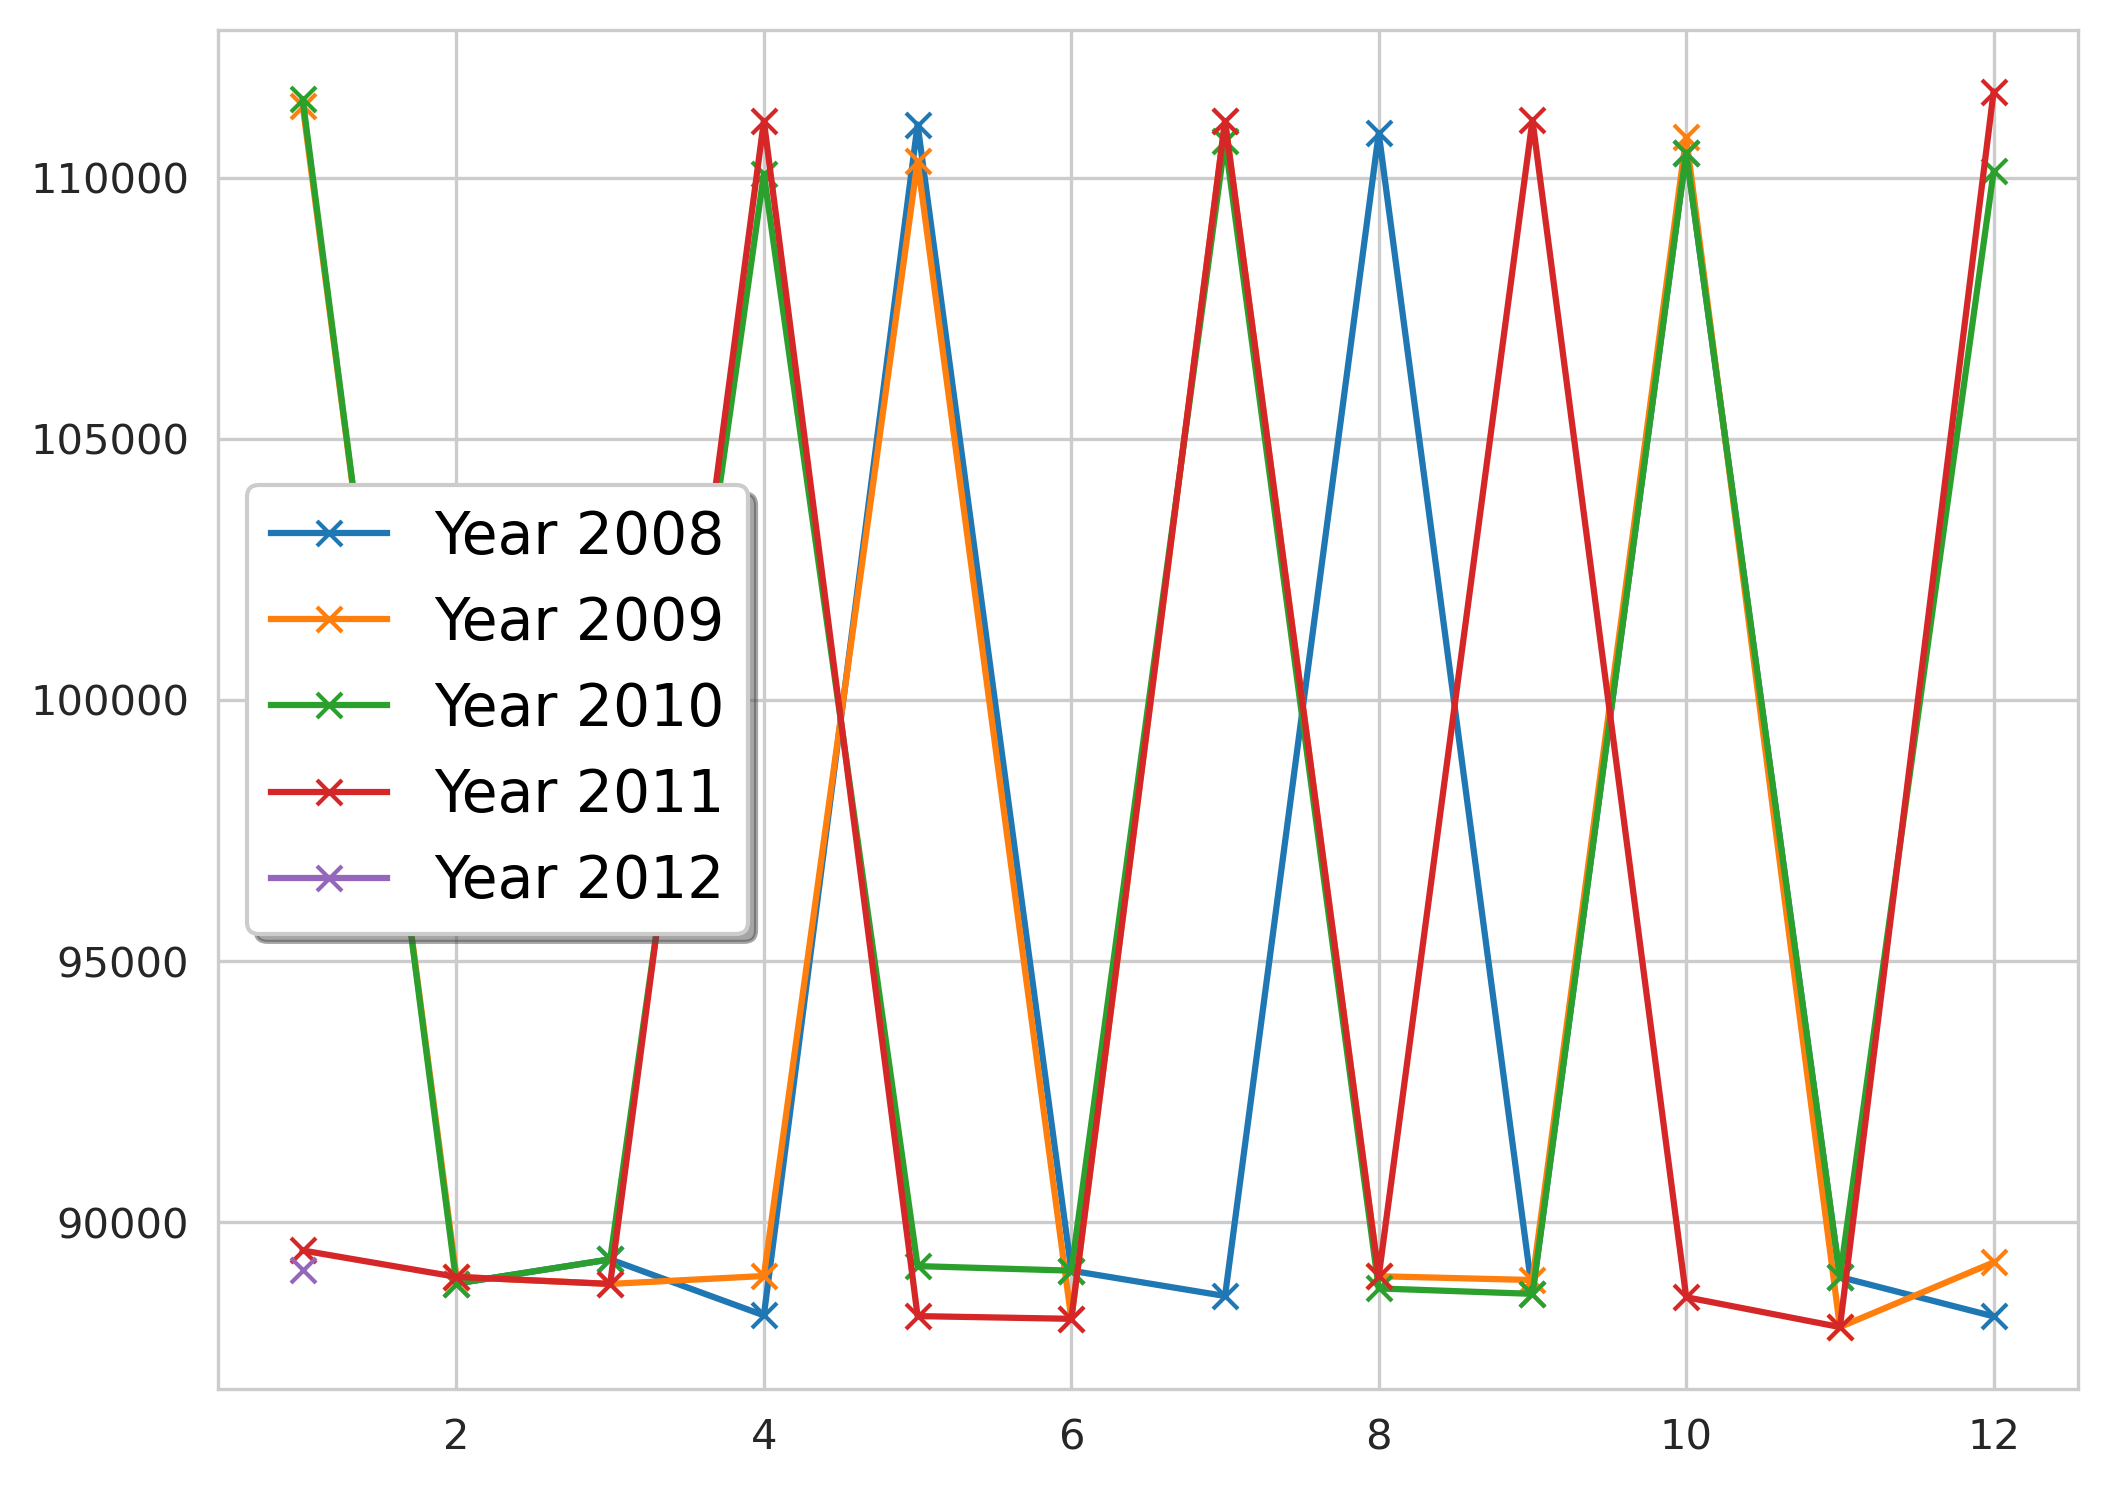

In [ ]:
a = df.groupby([df.index.year, df.index.month]).sum()['Weekly_Sales']
ax = start_plot(figsize=(8,6), dpi = 300)
for y in range(2008, 2013):
    b = a[y].reset_index()
    ax.plot(b.Date, b.Weekly_Sales, marker='x', 
            label = 'Year %d' % y)
ax.legend(shadow=True, fontsize=14)


## Here we go

In [ ]:
training_file = 'train_store_17_final.csv'
test_file = 'test_store_17_final.csv'
csv_training = os.path.join(data_dir, 'train_store_17_final.csv')
csv_test = os.path.join(data_dir, 'test_store_17_final.csv')
df1 = pd.read_csv(csv_training, parse_dates = ['Date'] , index_col = 'Date')
df2 = pd.read_csv(csv_test, parse_dates = ['Date'] , index_col = 'Date')

df = df1.append(df2)

split_points = len(df1) #切割點
df = df.drop(['Campaign2', 'Campaign3', 'Campaign4','Campaign5'], axis = 1)
df.IsHoliday = df.IsHoliday.map({False: 0, True:1}) # 將is HOliday轉換為0和1
# df.shape, df1.shape, df2.shape
train_df = df[:split_points]
test_df = df[split_points:]

y0 = df.Weekly_Sales
X0 = df.drop(['Weekly_Sales'], axis = 1)
train_y, test_y = y0[:split_points], y0[split_points:]

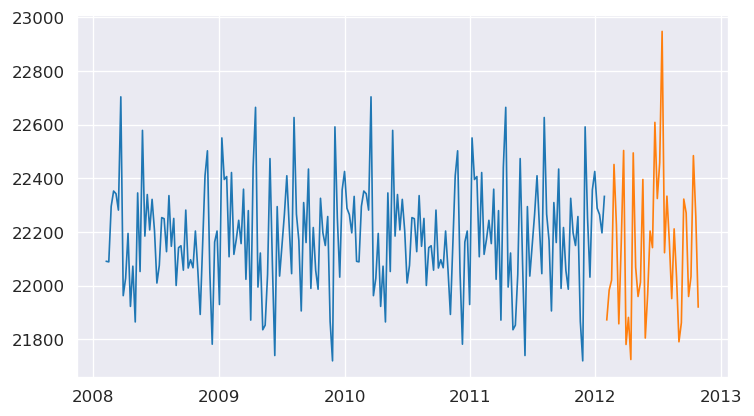

In [ ]:
ax = start_plot(style='darkgrid', figsize=(7, 4), dpi=120)
ax.plot(train_df.index, train_y, lw=1)
ax.plot(test_df.index, test_y, lw=1)

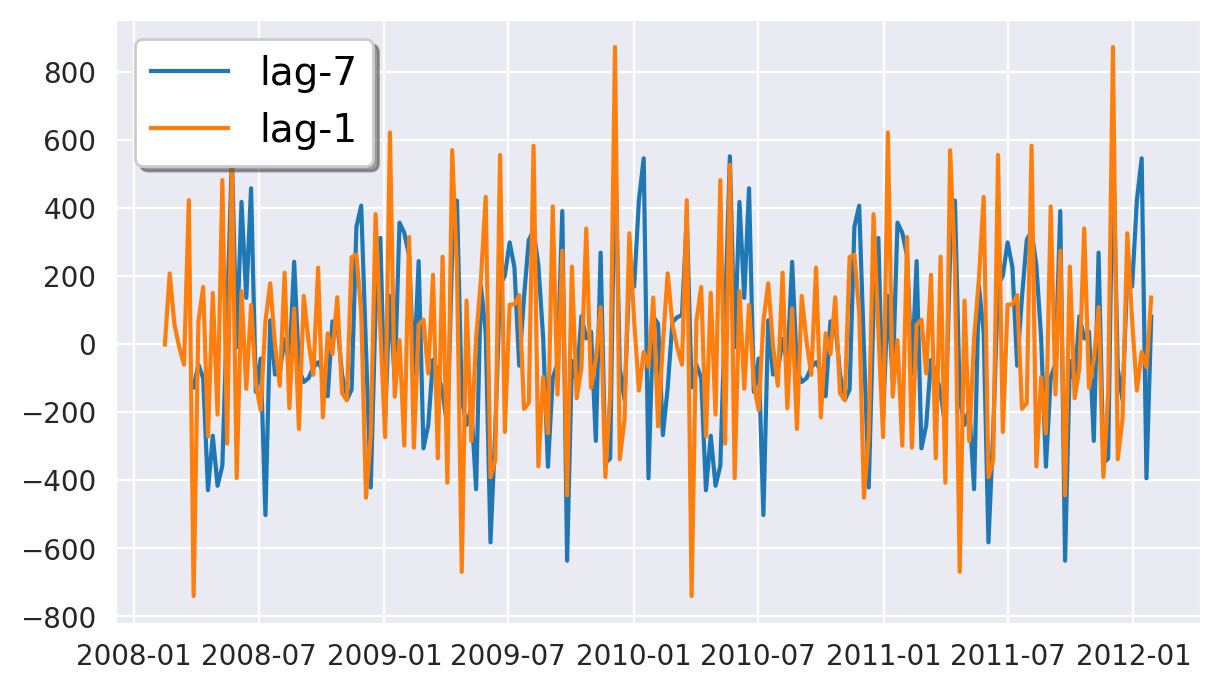

In [ ]:
ax = start_plot(style='darkgrid', figsize=(7, 4), dpi=200)
lags = 7
ax.plot(train_df.index, train_y.diff(lags), label='lag-%d' % lags)
ax.plot(train_df.index, train_y.diff(1), label='lag-1')
ax.legend(shadow=True, fontsize=14)

In [ ]:
yset = y0.copy().diff(7)[7:]
train_y = yset[:-len(test_df)]
test_y = yset[-len(test_df):]

train_y.shape, test_y.shape

((201,), (39,))

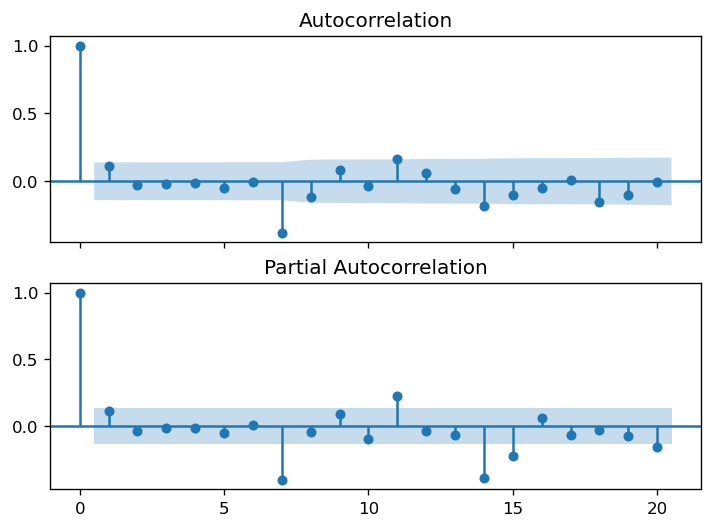

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 5), dpi=120, sharex=True)
plot_acf(train_y, lags=20, ax=ax[0])
plot_pacf(train_y, lags=20, ax=ax[1])
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARMA, ARIMA

arma = ARIMA(train_y, order=(7, 0, 1))
arma_fit = arma.fit(disp=False)
yhat = arma_fit.predict(1, len(test_df))

rmse = np.sqrt(mean_squared_error(test_y, yhat))
rmse

C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\wonglab\.conda\envs\Q\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred fre

419.34049274699487

419.34049274699487

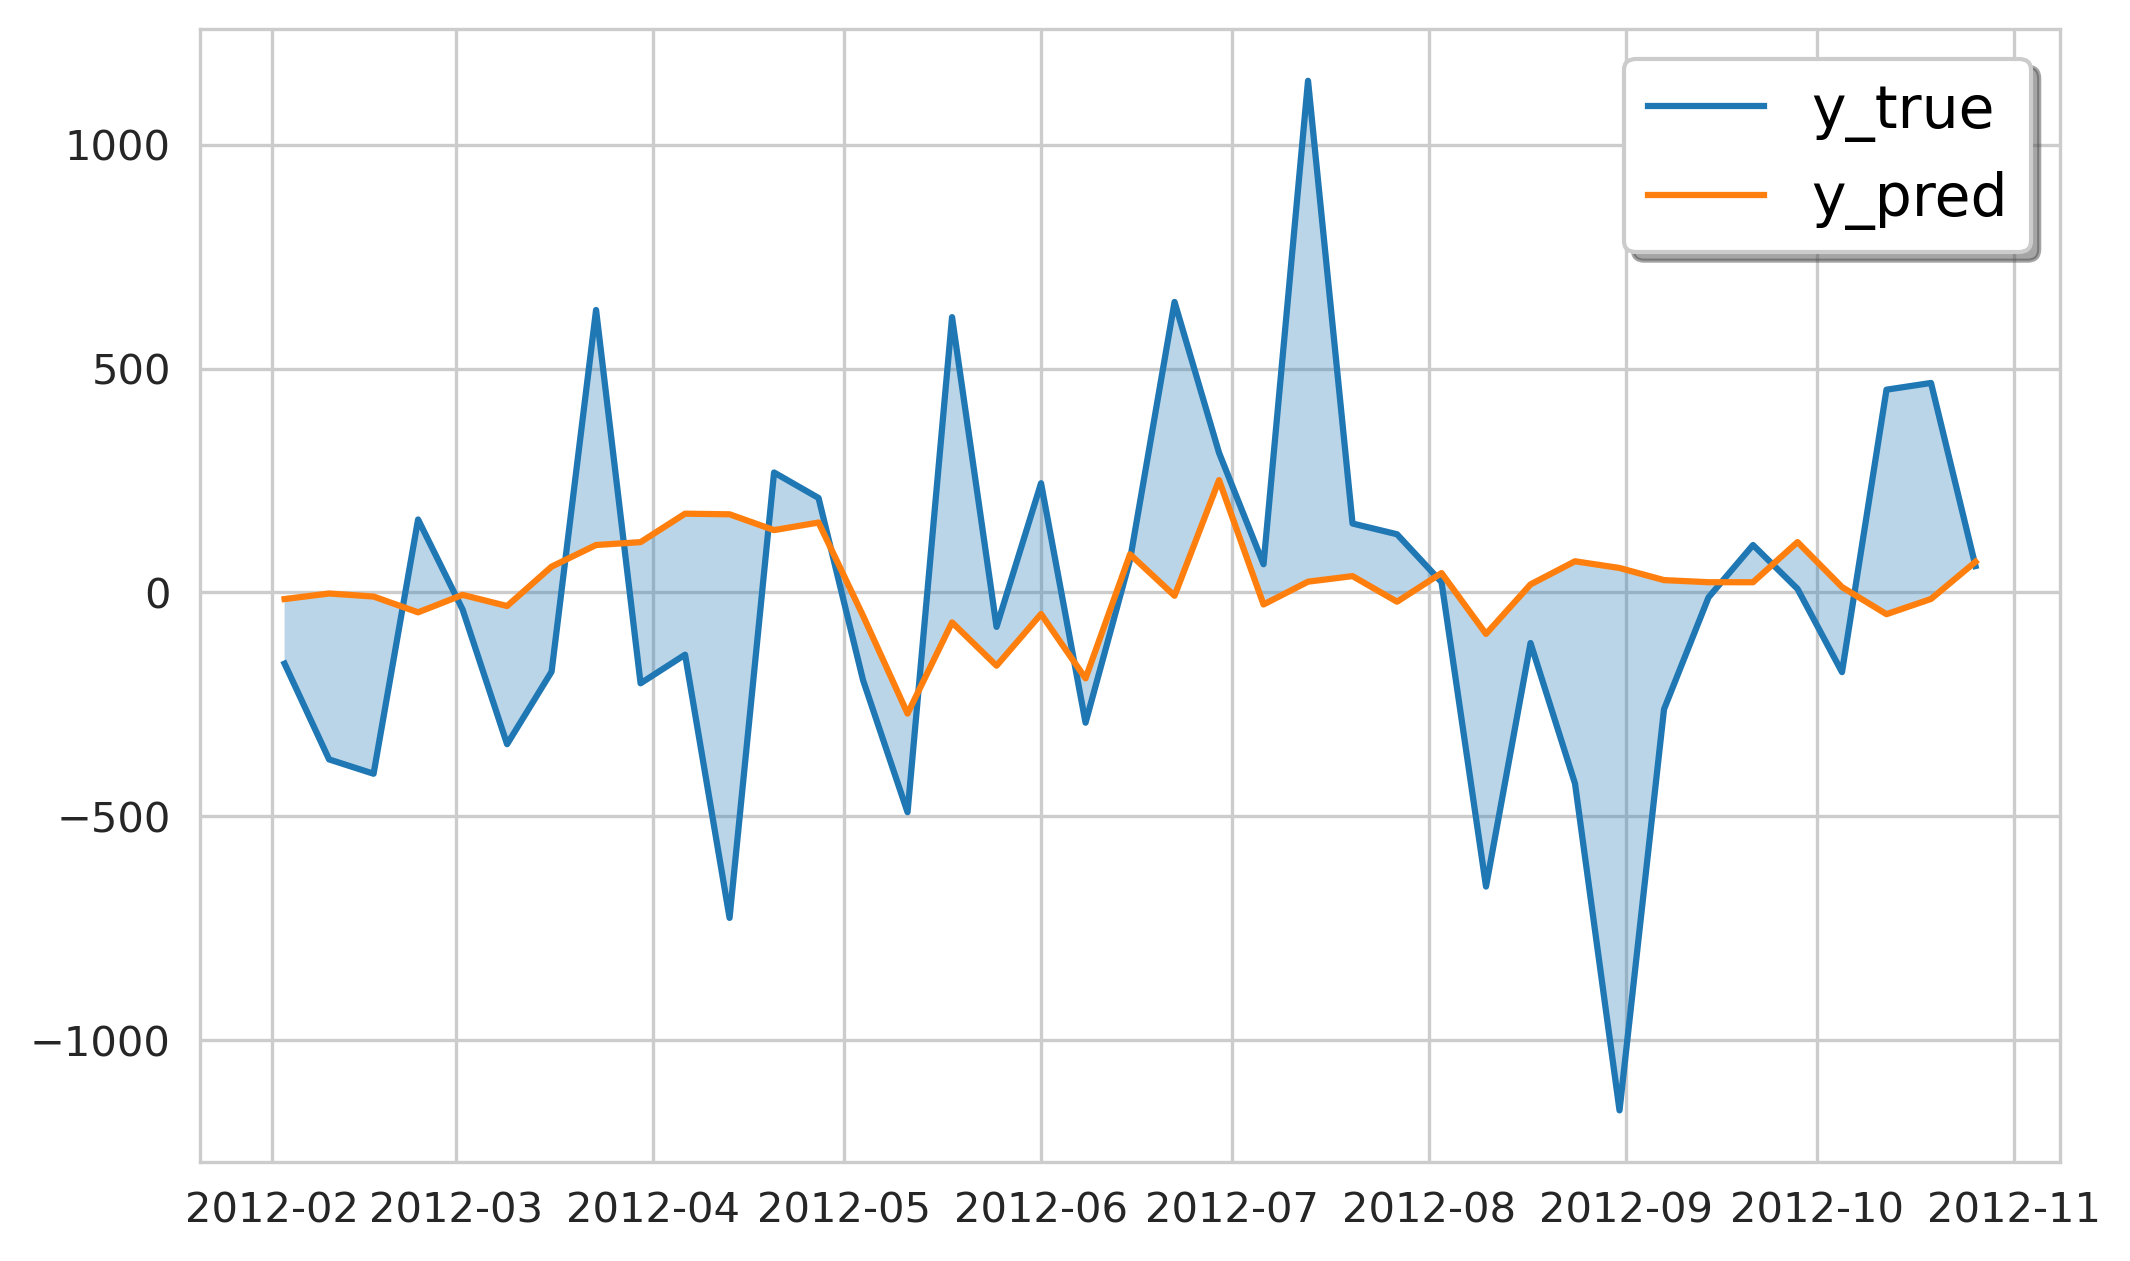

In [ ]:
ax = start_plot(figsize=(8, 5), dpi=300)
ax.plot(test_df.index, test_y, label='y_true')
ax.plot(test_df.index, yhat, label='y_pred')
ax.fill_between(test_df.index, test_y, yhat, alpha=0.3)
ax.legend(shadow=True, fontsize=14)
rmse

# End of File ☹